In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
import seaborn as sns

colours = {
    'cucumbers': 'palegreen',
    'guitars': 'peru',
    'slingshots': 'violet',
    'stocks': 'tomato',
    'sugar': 'palegoldenrod',
    'water': 'skyblue',
    'tranquillity': 'pink'
}
# Load data
df = pd.read_csv('spiff_data.csv')

# Clean/reformat dataframe
df.rename(columns={'gurkor':'cucumbers'}, inplace=True)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.iloc[:, 1:] = df.iloc[:, 1:].replace(1000.0, np.nan)

# Save the cleaned dataframe to a new CSV file
df.to_csv('spiff_data_cleaned.csv', index=False)

while df.iloc[-1, 1:].isnull().all():  # Check if all columns except the first are empty in the last row
    df = df.iloc[:-1]  # Remove the last row
    
df.to_csv('spiff_data_cleaned_croped.csv', index=False)

#df = df.interpolate(method='linear', limit_direction='both') 
df = df.interpolate(method='cubic', limit_direction='both')

df.to_csv('spiff_data_cleaned_croped_filed.csv', index=False)

In [134]:
df.head()

day  cucumbers   guitars  slingshots     stocks     sugar     water  \
0    1   6.154653  2.794285    2.136536  10.653684  3.324896  3.896149   
1    2   6.189623  2.843068    2.113582  10.674465  3.355736  3.899915   
2    3   6.168641  2.839644    2.116336  10.822372  3.336461  3.897404   
3    4   6.156401  2.823384    2.096137  10.848804  3.288274  3.901170   
4    5   6.124929  2.832798    2.099810  10.860731  3.303694  3.905355   

   tranquillity  
0      7.755880  
1      7.781310  
2      7.886205  
3      7.848061  
4      7.883026

In [105]:
summary_stats = df.describe()
summary_stats

day    cucumbers      guitars   slingshots       stocks  \
count  5256.000000  5256.000000  5256.000000  5256.000000  5256.000000   
mean   2628.500000     8.934396     5.760556     3.560619     6.346037   
std    1517.420838     2.256389     1.747840     0.968471     2.129868   
min       1.000000     5.942896     2.629048     2.001362     4.012346   
25%    1314.750000     6.952855     4.292716     2.816370     4.922768   
50%    2628.500000     8.905505     5.907840     3.383130     5.520531   
75%    3942.250000    10.167648     7.038099     4.281331     6.878430   
max    5256.000000    14.132395    10.719387     6.468982    13.613052   

             sugar        water  tranquillity  
count  5256.000000  5256.000000   5256.000000  
mean      2.662923     5.794380     11.542794  
std       0.723220     1.268336      3.053129  
min       1.370262     3.739412      6.614749  
25%       2.003540     5.003922      9.210108  
50%       2.605522     5.774852     10.584870  
75%       3.277633     6.479277     13.338366  
max       4.125193     8.949187     21.137953

In [113]:
# Zero lag correlation matrix

# NaN-aware lag-0 Pearson correlation
def nan_corr(x, y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    if mask.sum() == 0:
        return np.nan  # No overlap
    return np.corrcoef(x[mask], y[mask])[0, 1]

# Compute the full lag-0 correlation matrix
cols = df.columns
n = len(cols)
corr_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)

for i in range(n):
    for j in range(n):
        corr_matrix.iloc[i, j] = nan_corr(df.iloc[:, i].values,
                                          df.iloc[:, j].values)

# Display
corr_matrix

day  cucumbers   guitars  slingshots    stocks     sugar  \
day           1.000000   0.950235  0.423446    0.815511 -0.653105 -0.686130   
cucumbers     0.950235   1.000000  0.259500    0.758605 -0.522626 -0.681564   
guitars       0.423446   0.259500  1.000000    0.626859 -0.633140 -0.058465   
slingshots    0.815511   0.758605  0.626859    1.000000 -0.509960 -0.280102   
stocks       -0.653105  -0.522626 -0.633140   -0.509960  1.000000  0.531193   
sugar        -0.686130  -0.681564 -0.058465   -0.280102  0.531193  1.000000   
water         0.961808   0.970902  0.407263    0.822204 -0.636241 -0.675086   
tranquillity  0.644111   0.538918  0.373407    0.740271 -0.279184 -0.098256   

                 water  tranquillity  
day           0.961808      0.644111  
cucumbers     0.970902      0.538918  
guitars       0.407263      0.373407  
slingshots    0.822204      0.740271  
stocks       -0.636241     -0.279184  
sugar        -0.675086     -0.098256  
water         1.000000      0.524177  
tranquillity  0.524177      1.000000

In [114]:
corr = df.drop(columns='day').corr()
corr

cucumbers   guitars  slingshots    stocks     sugar     water  \
cucumbers      1.000000  0.259500    0.758605 -0.522626 -0.681564  0.970902   
guitars        0.259500  1.000000    0.626859 -0.633140 -0.058465  0.407263   
slingshots     0.758605  0.626859    1.000000 -0.509960 -0.280102  0.822204   
stocks        -0.522626 -0.633140   -0.509960  1.000000  0.531193 -0.636241   
sugar         -0.681564 -0.058465   -0.280102  0.531193  1.000000 -0.675086   
water          0.970902  0.407263    0.822204 -0.636241 -0.675086  1.000000   
tranquillity   0.538918  0.373407    0.740271 -0.279184 -0.098256  0.524177   

              tranquillity  
cucumbers         0.538918  
guitars           0.373407  
slingshots        0.740271  
stocks           -0.279184  
sugar            -0.098256  
water             0.524177  
tranquillity      1.000000

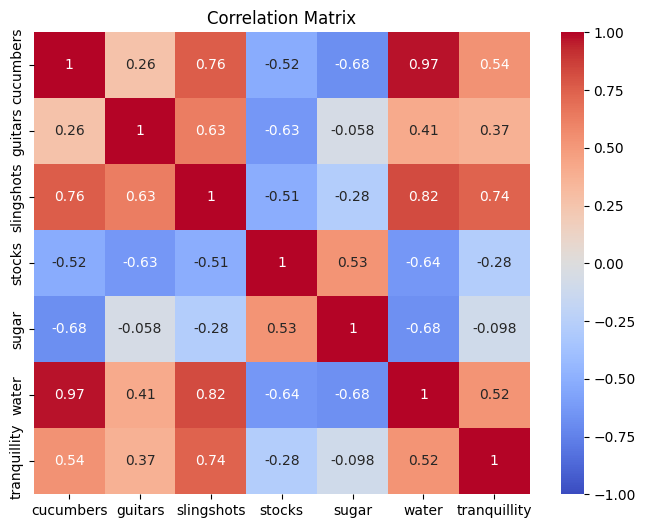

In [133]:
df=df.dropna()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

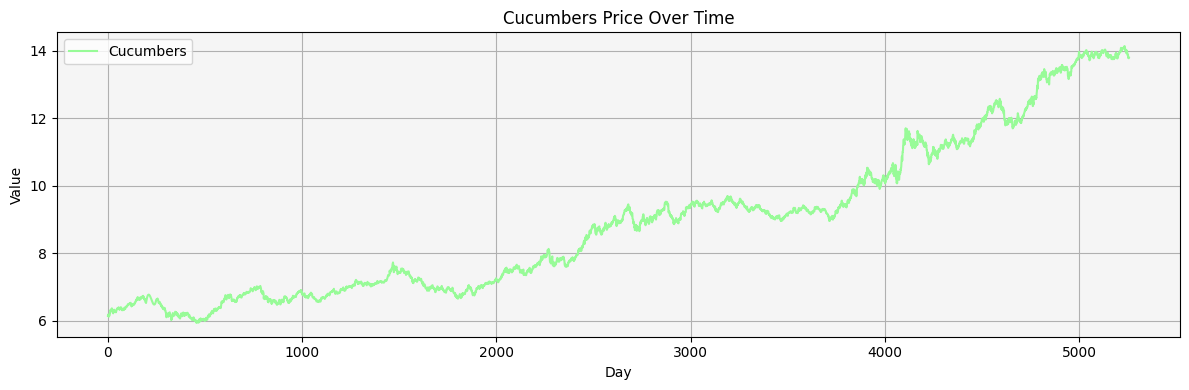

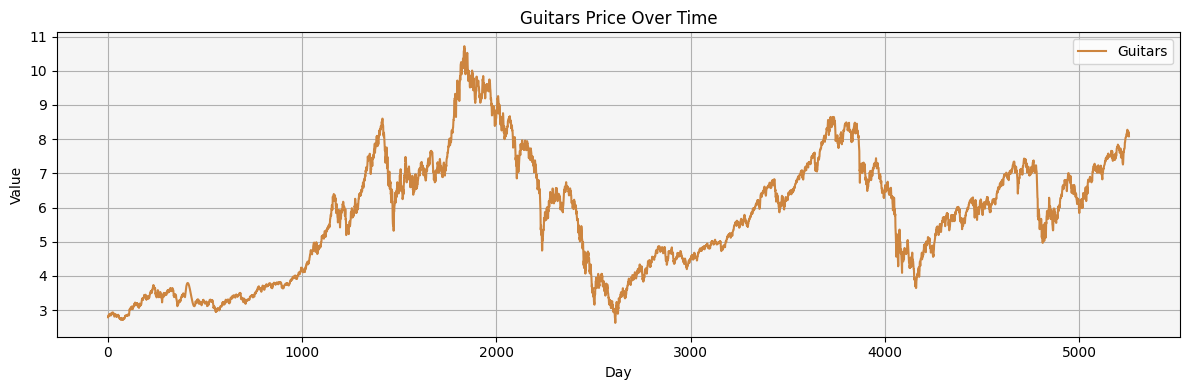

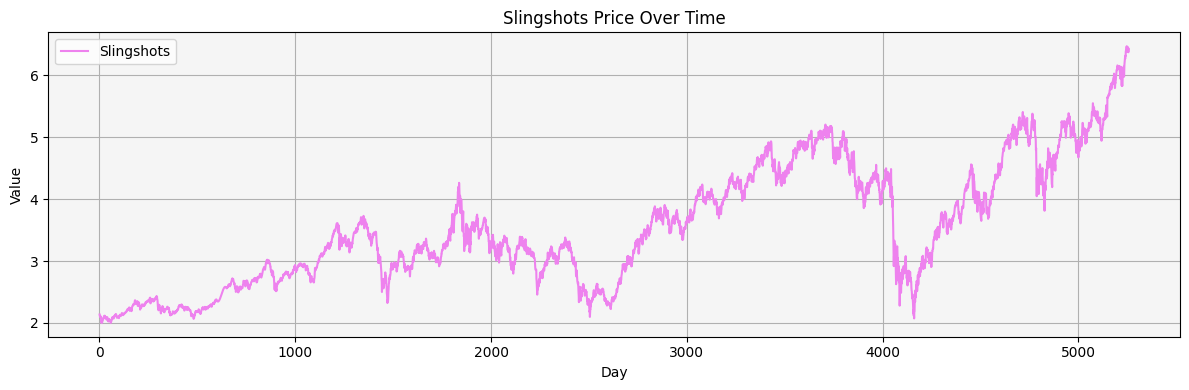

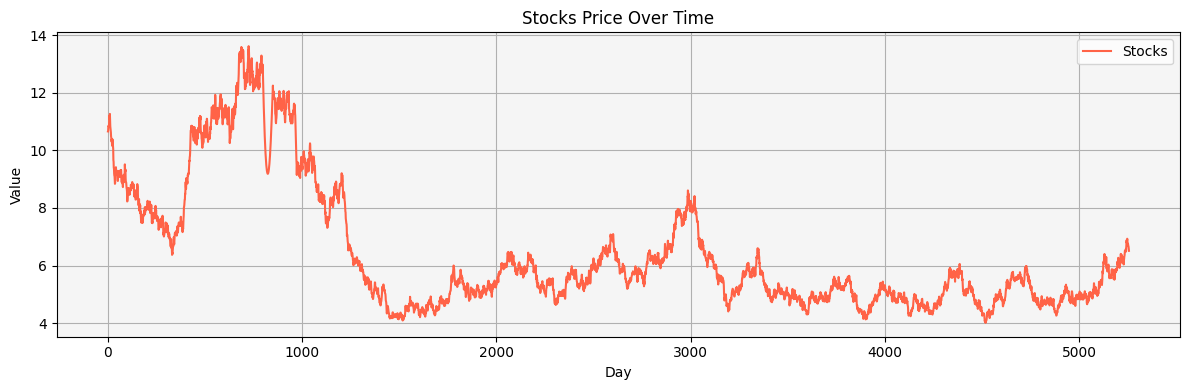

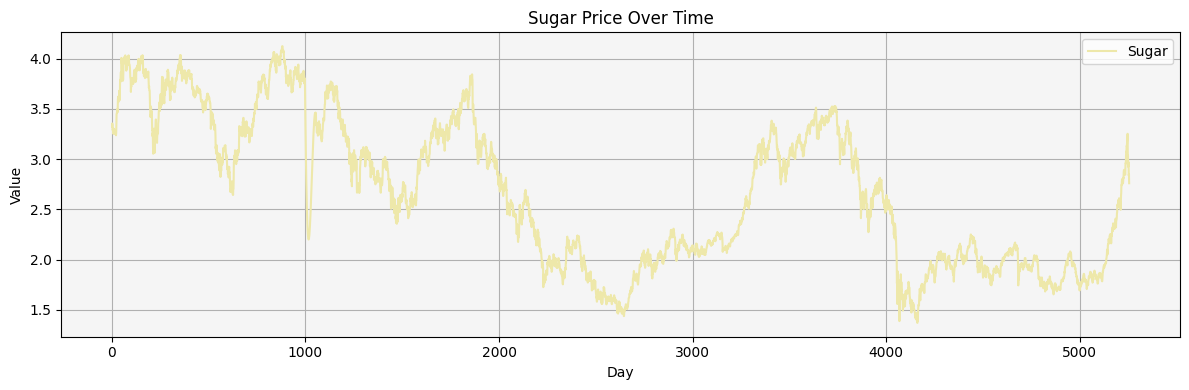

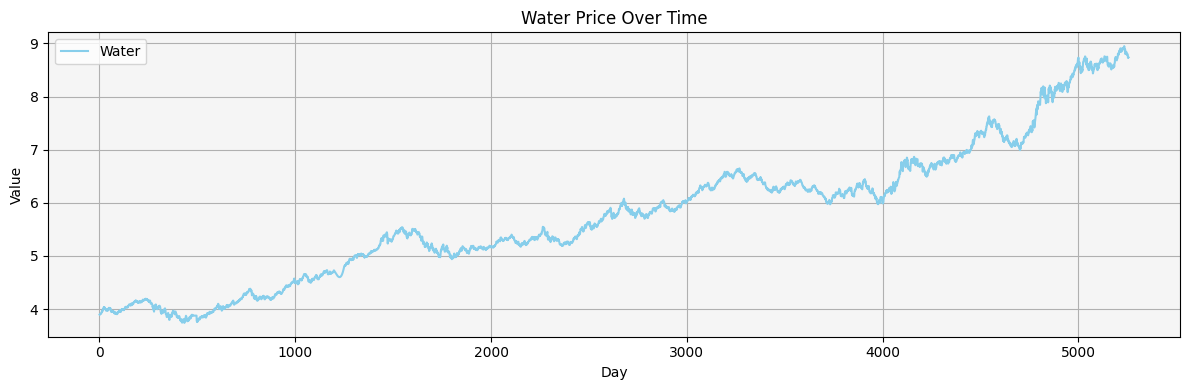

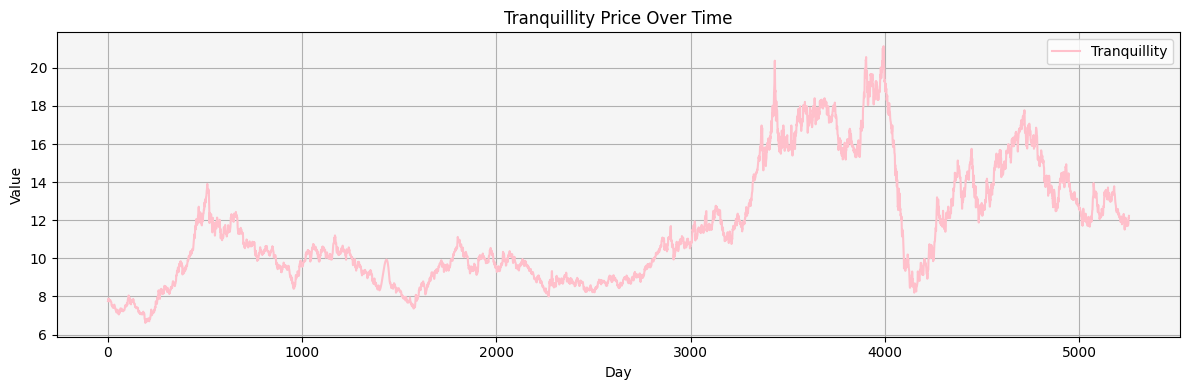

In [129]:
# Create a separate plot for each column
for column, color in colours.items():
    plt.figure(figsize=(12, 4))
    plt.plot(df['day'], df[column], color=color, label=column.capitalize())
    plt.title(f'{column.capitalize()} Price Over Time')
    plt.xlabel('Day')
    plt.ylabel('Value')
    plt.grid(True)
    plt.gca().set_facecolor("whitesmoke")
    plt.legend()
    plt.tight_layout()
    plt.show()

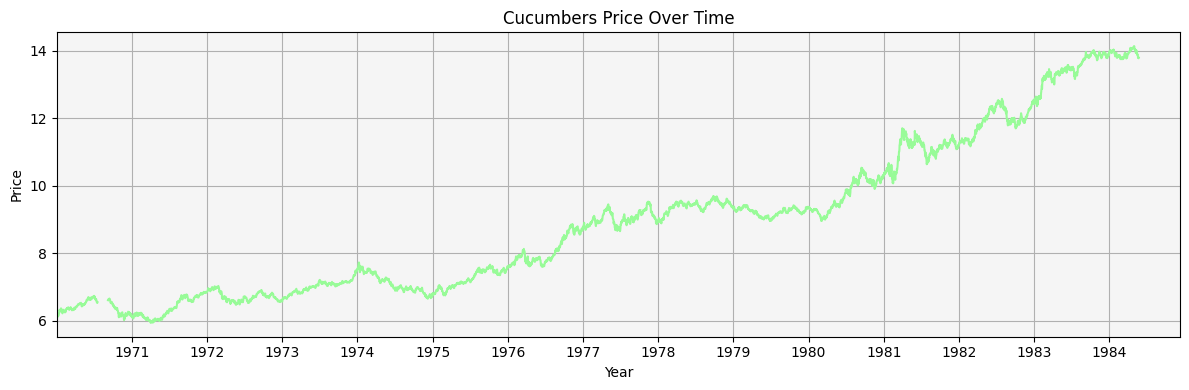

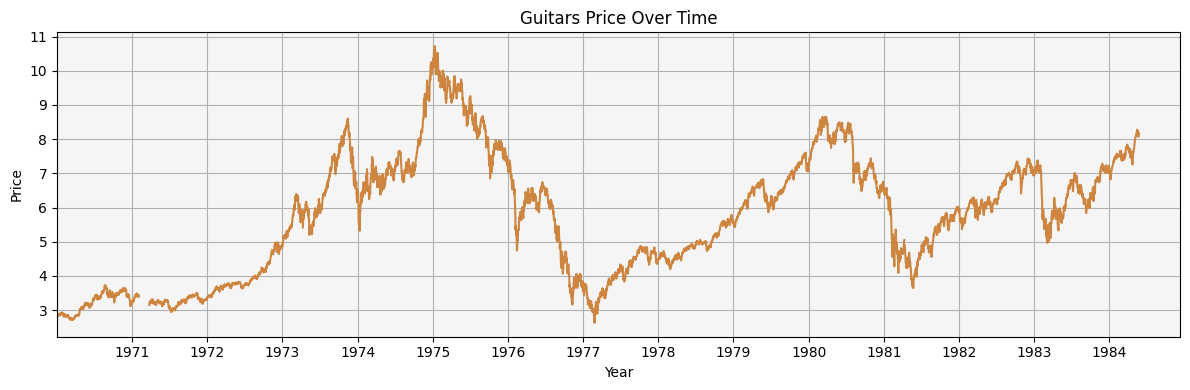

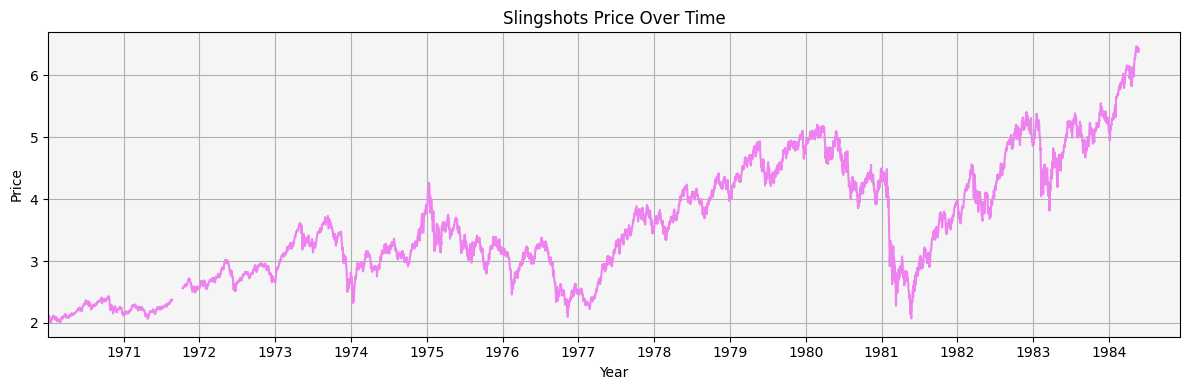

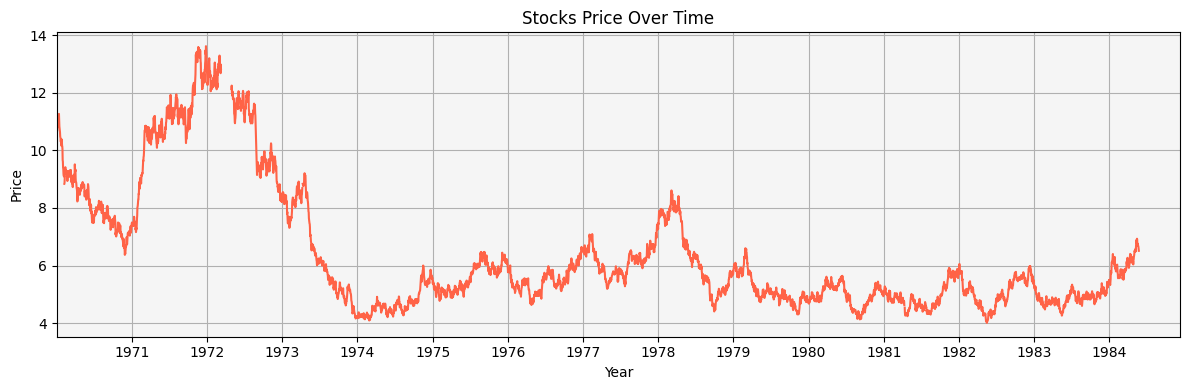

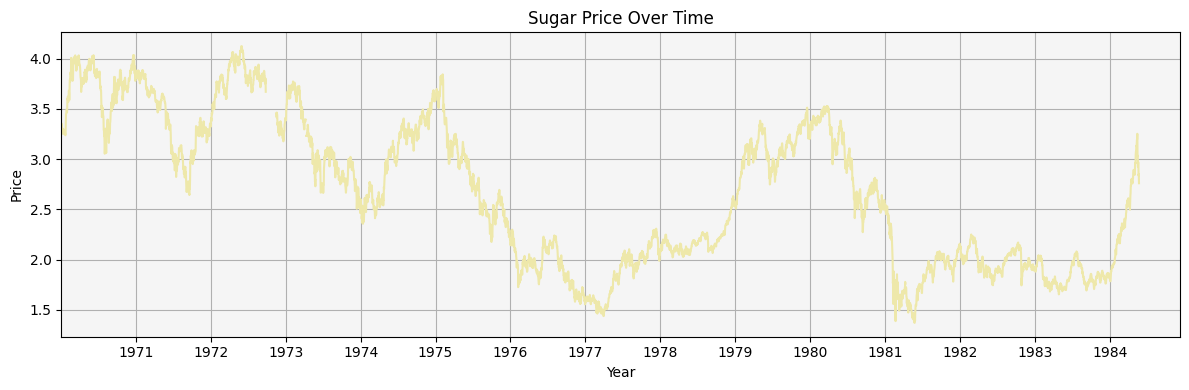

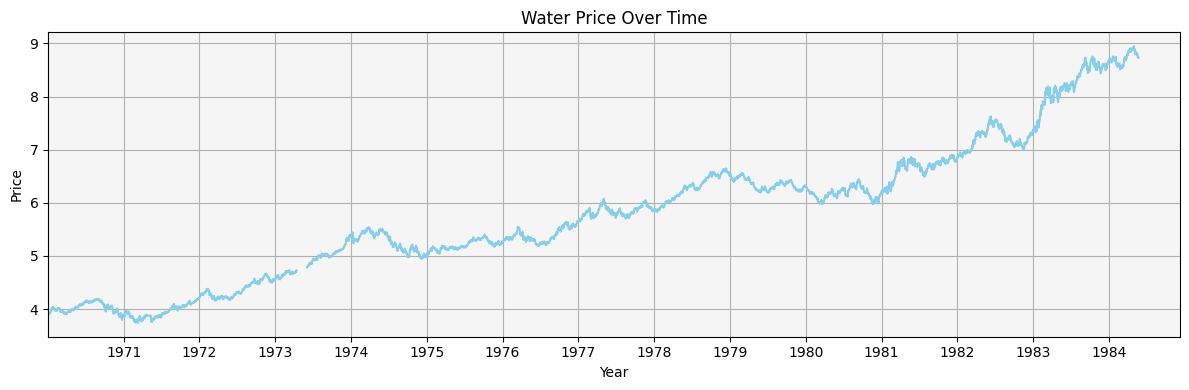

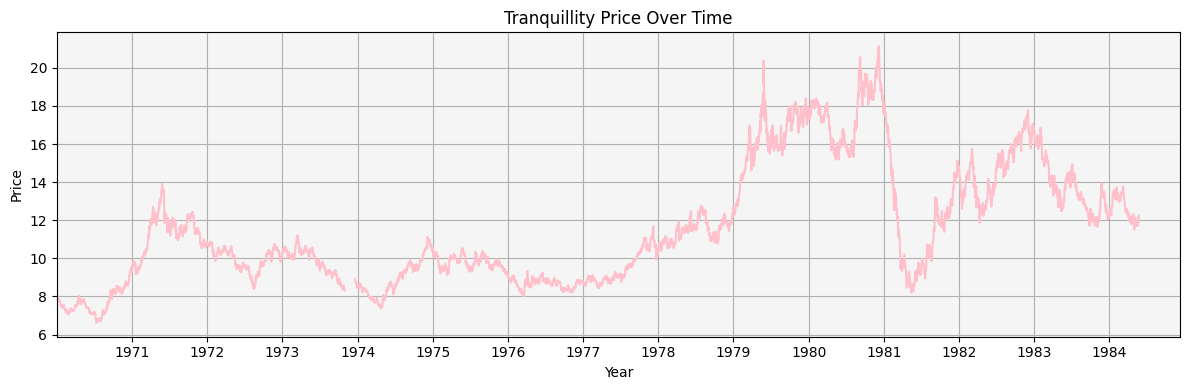

In [124]:
# Load and prepare data
dft = pd.read_csv("spiff_data.csv")
dft.rename(columns={'gurkor': 'cucumbers'}, inplace=True)

# Convert 'day' to datetime (if needed)
dft['day'] = pd.to_datetime(dft['day'], errors='coerce')

# Keep 'day' and other useful columns
dft_clean = dft.drop(columns=["Unnamed: 0"])
dft_clean = dft_clean.replace(1000.0, np.nan)
dft_clean.set_index('day', inplace=True)

# Color dictionary
colours = {
    'cucumbers': 'palegreen',
    'guitars': 'peru',
    'slingshots': 'violet',
    'stocks': 'tomato',
    'sugar': 'palegoldenrod',
    'water': 'skyblue',
    'tranquillity': 'pink'
}

# Create a separate plot for each item
for column, color in colours.items():
    ax = dft_clean[[column]].plot(figsize=(12, 4), color=color, legend=False)
    ax.set_title(f'{column.capitalize()} Price Over Time')
    ax.set_xlabel('Year')
    ax.set_ylabel('Price')
    ax.grid(True)
    ax.set_facecolor("whitesmoke")

    # Format x-axis by year
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

    plt.tight_layout()
    plt.show()


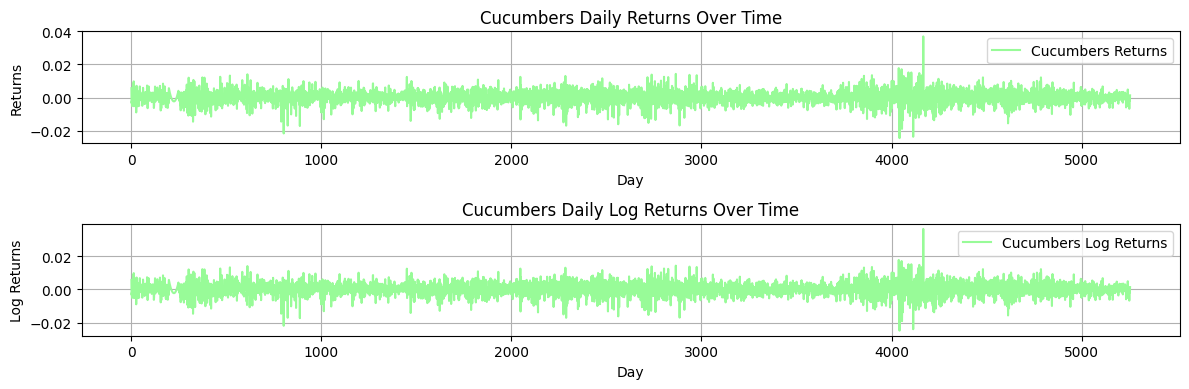

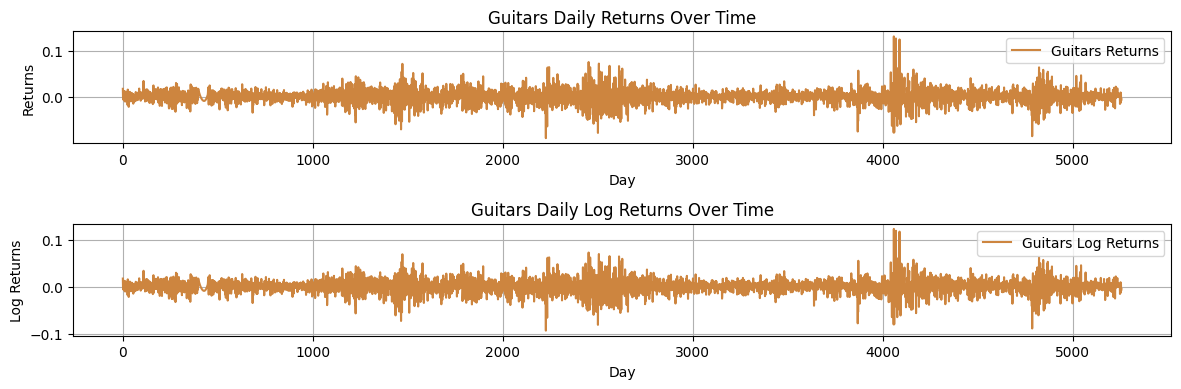

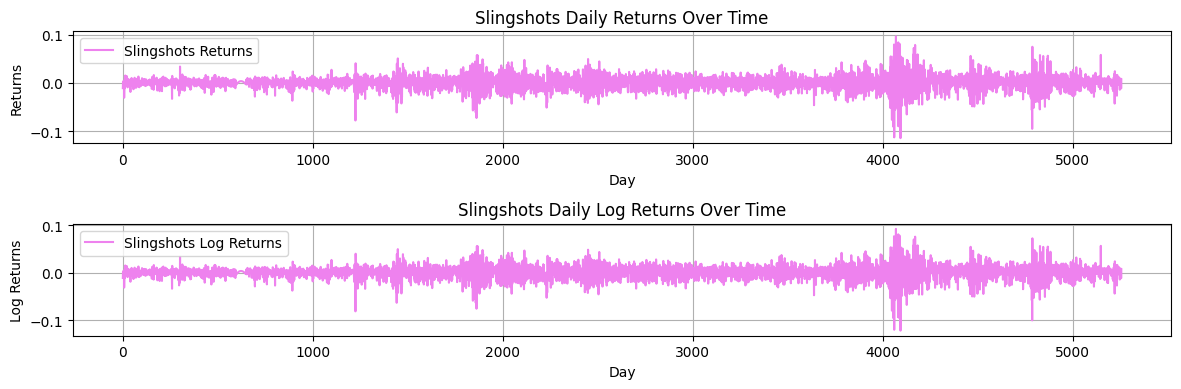

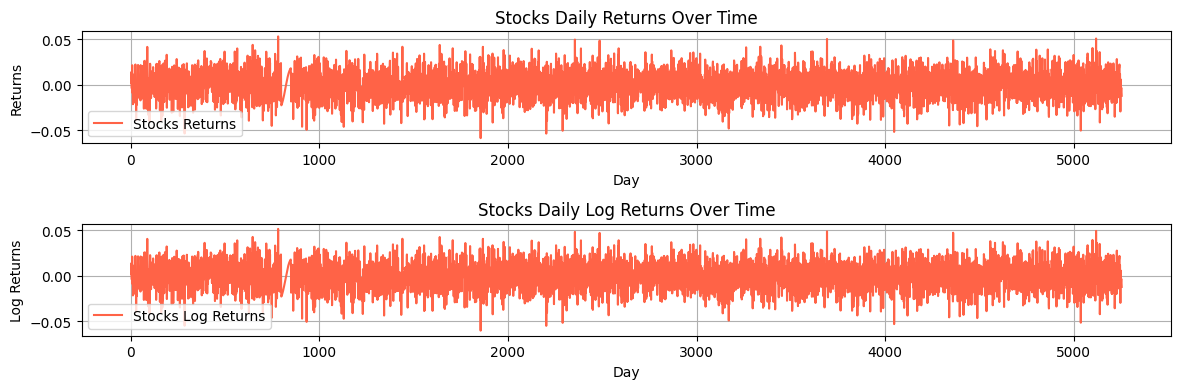

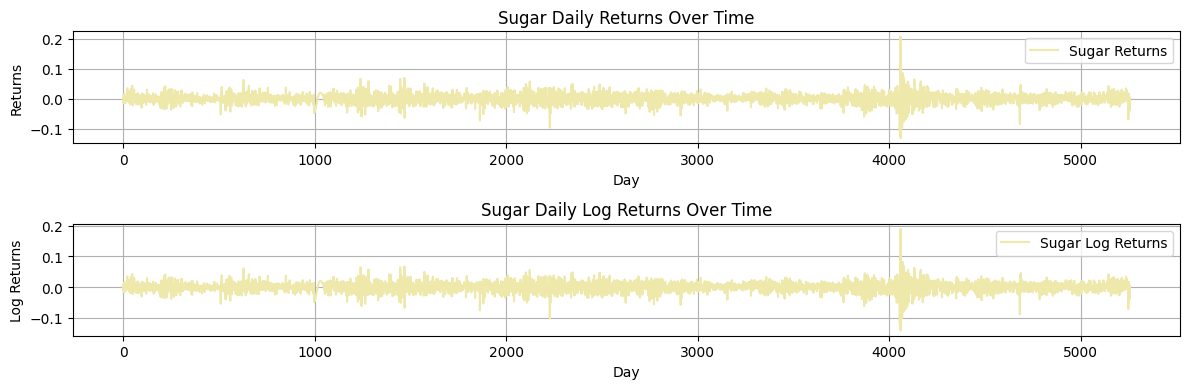

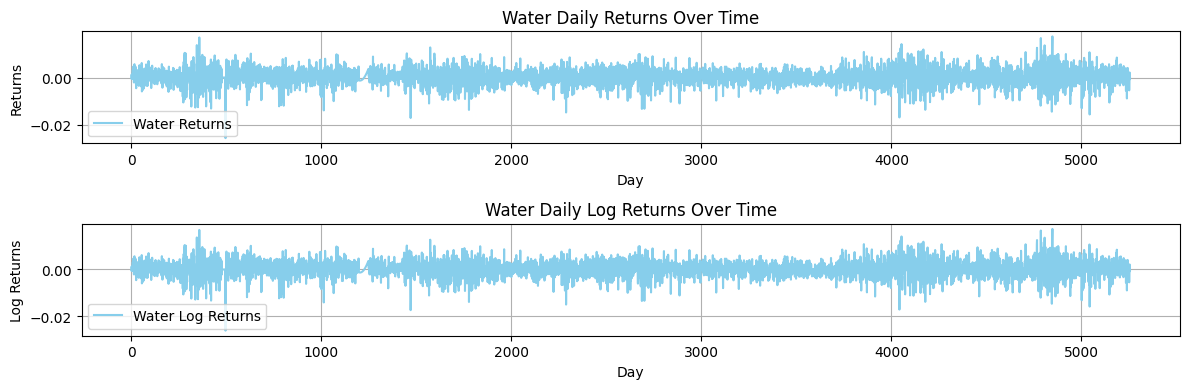

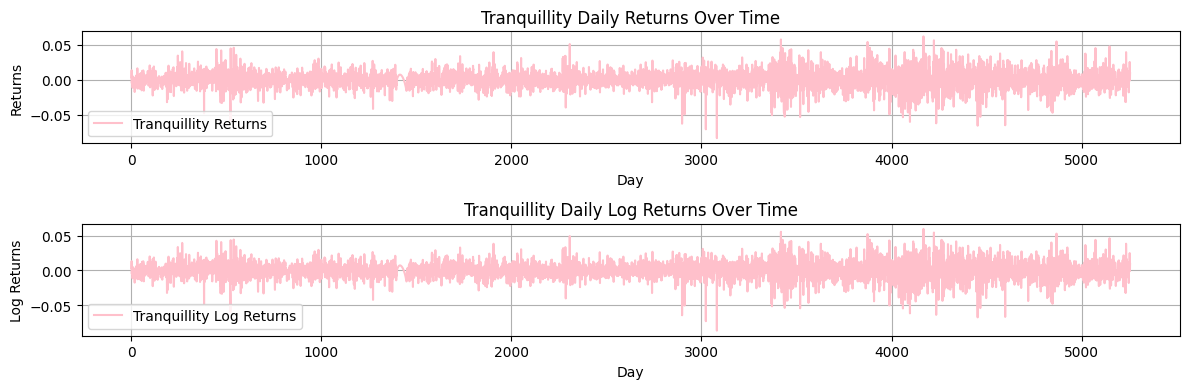

In [118]:
# Calculate daily returns and log returns for each column
returns = df[colours.keys()].pct_change(fill_method=None)  # Avoid deprecated default behavior
returns = returns.dropna()  # Drop NaN values after calculation

# Logarithmic returns
df_fixed = df[colours.keys()].replace(0, np.nan)  # Replace zeros with NaN to avoid division issues
log_returns = np.log(df_fixed / df_fixed.shift(1))  # Logarithmic returns
log_returns = log_returns.dropna()  # Drop NaN values

# Loop through each column for plotting
for column, color in colours.items():
    plt.figure(figsize=(12, 4))
    
    # Plot returns
    plt.subplot(2, 1, 1)
    plt.plot(returns[column], color=color, label=f'{column.capitalize()} Returns')
    plt.title(f'{column.capitalize()} Daily Returns Over Time')
    plt.xlabel('Day')
    plt.ylabel('Returns')
    plt.grid(True)
    plt.legend()

    # Plot log returns
    plt.subplot(2, 1, 2)
    plt.plot(log_returns[column], color=color, label=f'{column.capitalize()} Log Returns')
    plt.title(f'{column.capitalize()} Daily Log Returns Over Time')
    plt.xlabel('Day')
    plt.ylabel('Log Returns')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


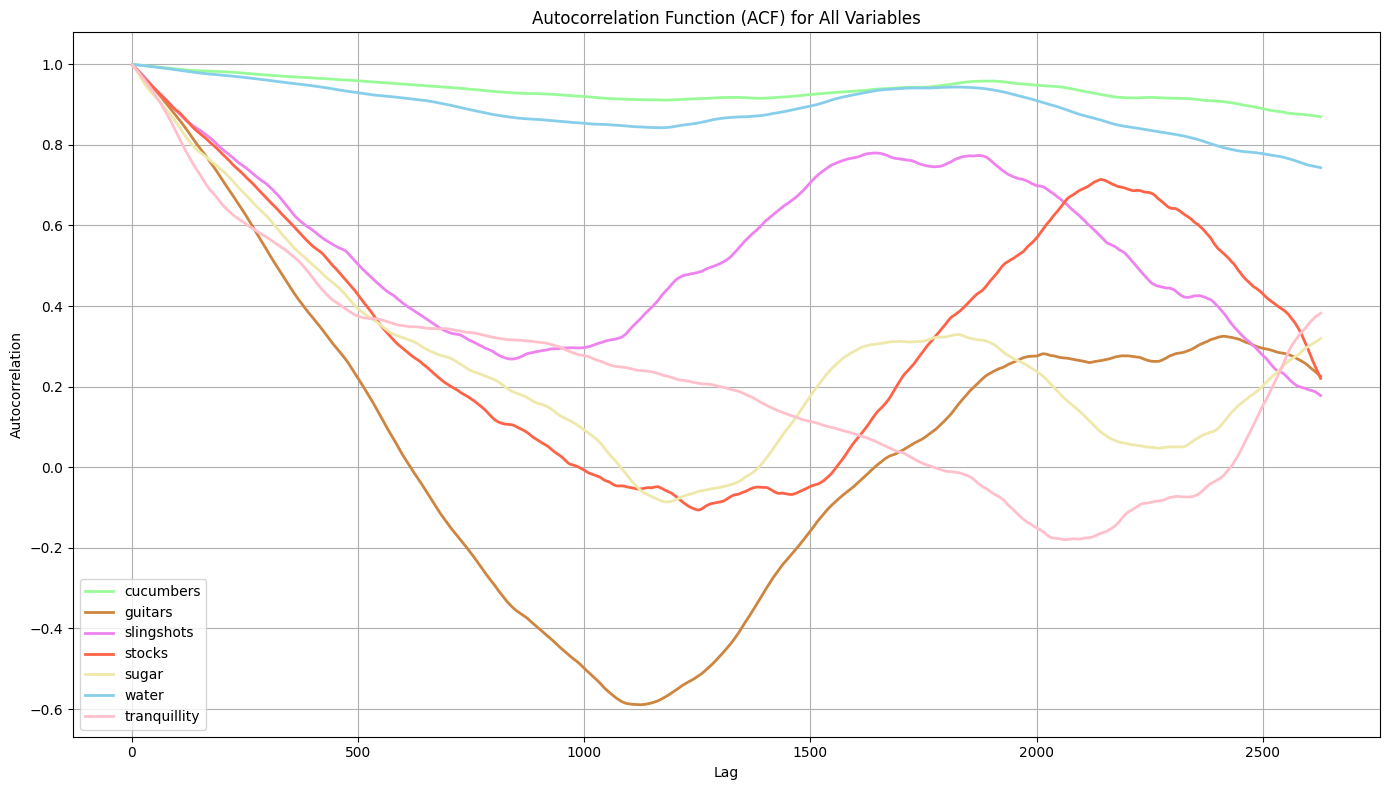

In [119]:
# Plot autocorrelations for all columns
plt.figure(figsize=(14, 8))
max_lag = len(df) // 2

for i, column in enumerate(colours.keys()):
    series = df[column].dropna()
    autocorrelations = [series.autocorr(lag) for lag in range(1, max_lag + 1)]
    plt.plot(range(1, max_lag + 1), autocorrelations, label=column, color=colours[column], linewidth=2)

plt.title('Autocorrelation Function (ACF) for All Variables')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

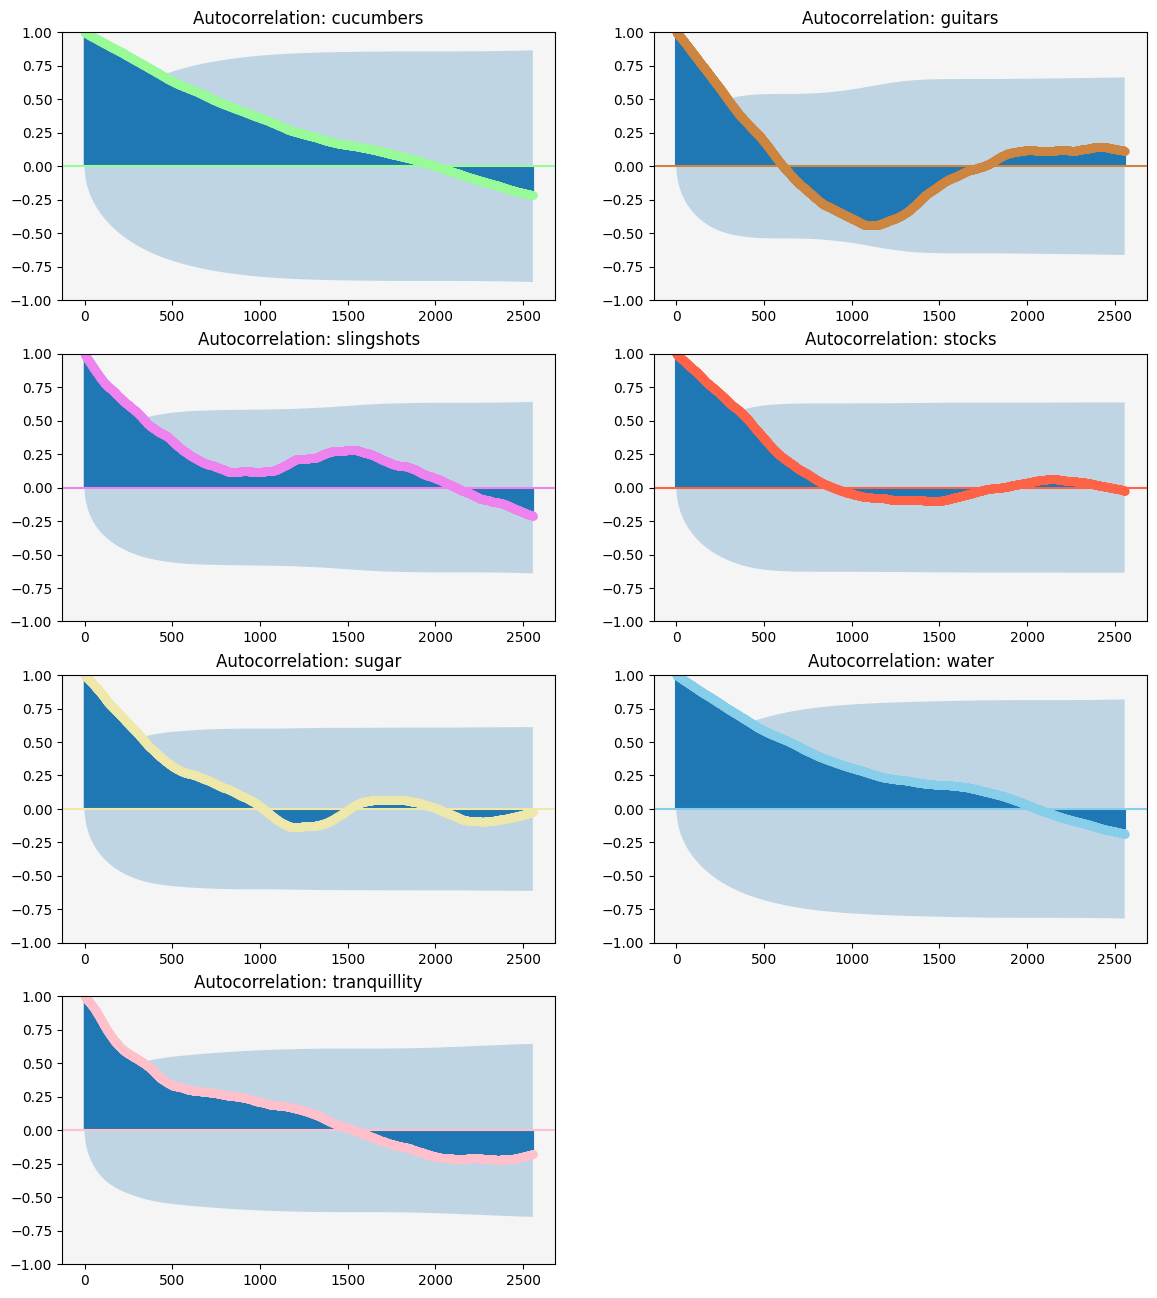

In [82]:
fig, axes = plt.subplots(4, 2, figsize=(14, 4*4))
axes = axes.flatten()
# Create individual ACF plots
for i, (column, color) in enumerate(colours.items()):
    series = df[column].dropna()
    plot_acf(series, lags=min(365*7, len(series) // 2), ax=axes[i], title=f"Autocorrelation: {column}", color=color)
    axes[i].set_facecolor("whitesmoke")

fig.delaxes(axes[7])


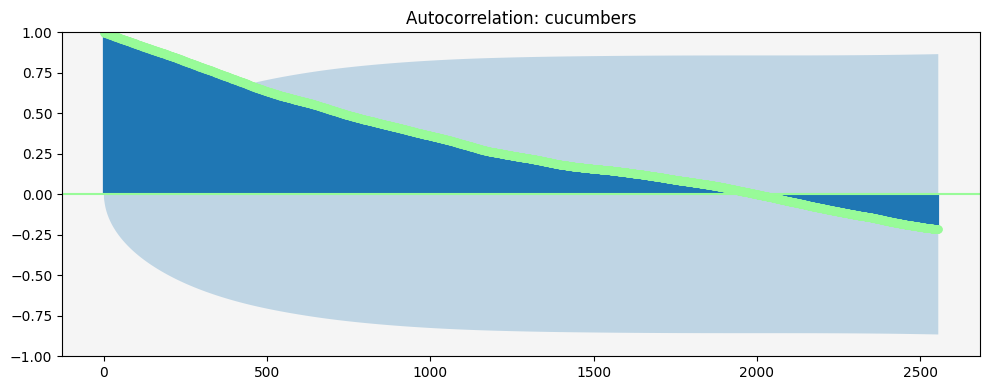

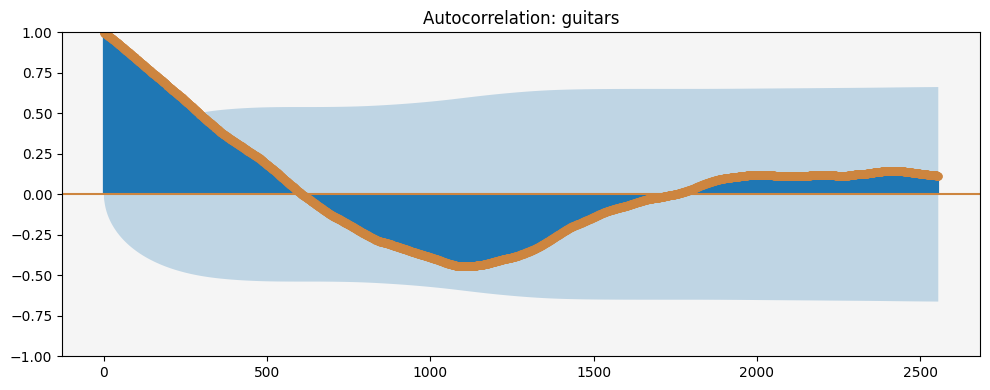

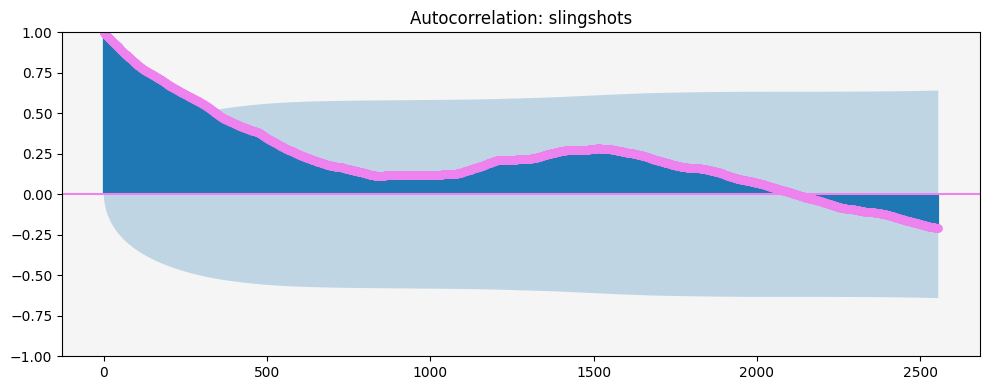

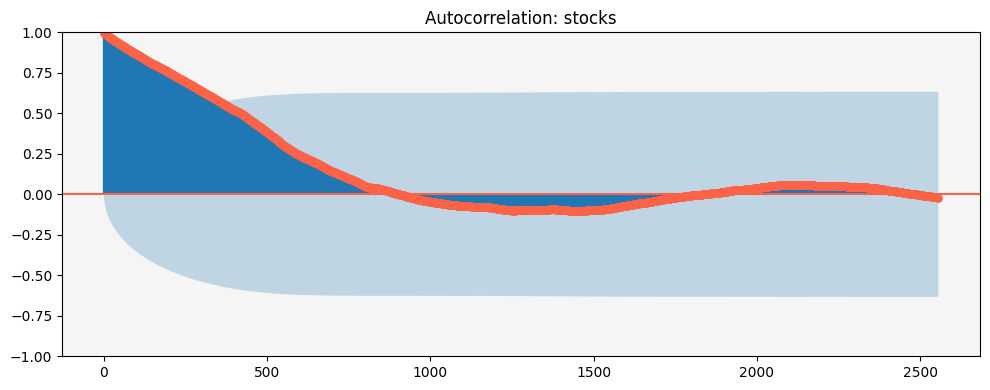

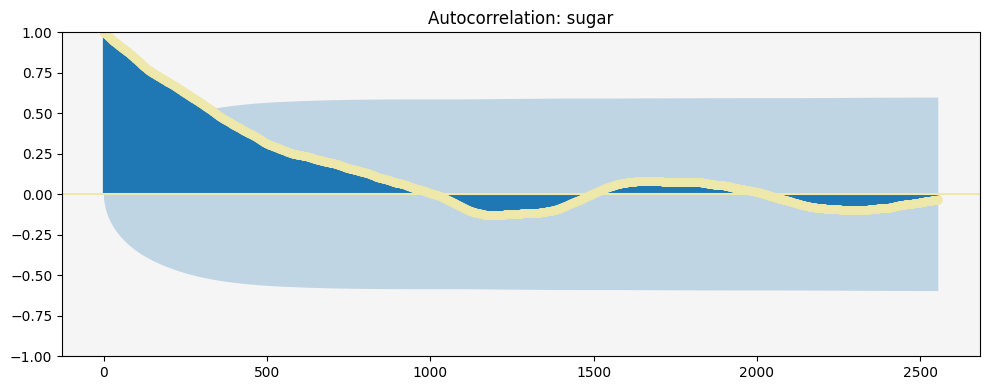

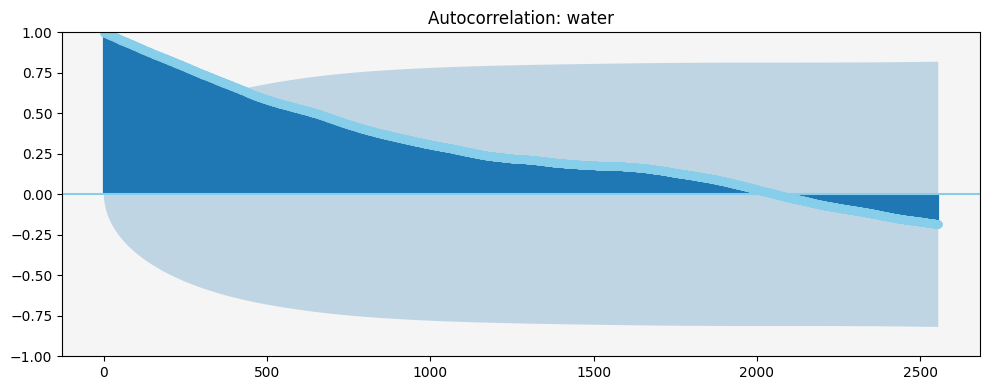

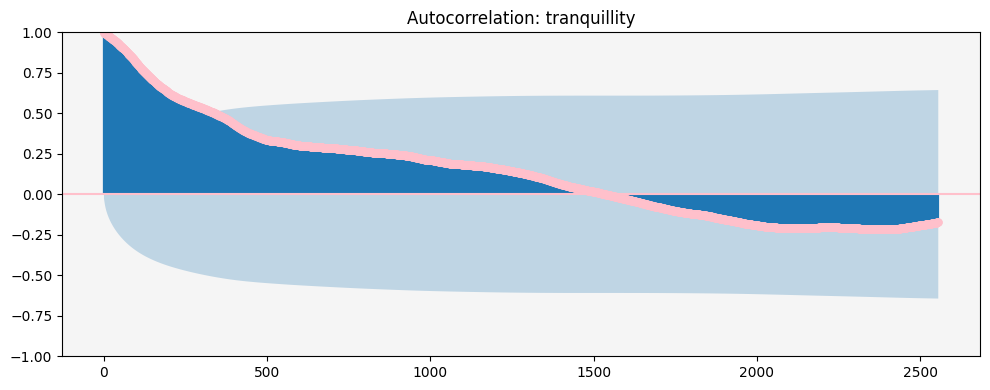

In [120]:


# Create individual ACF plots
for column, color in colours.items():
    series = df[column].dropna()

    fig, ax = plt.subplots(figsize=(10, 4))
    plot_acf(series, lags=min(365*7, len(series) // 2), ax=ax, title=f"Autocorrelation: {column}", color=color)
    ax.set_facecolor("whitesmoke")
    plt.tight_layout()
    plt.show()


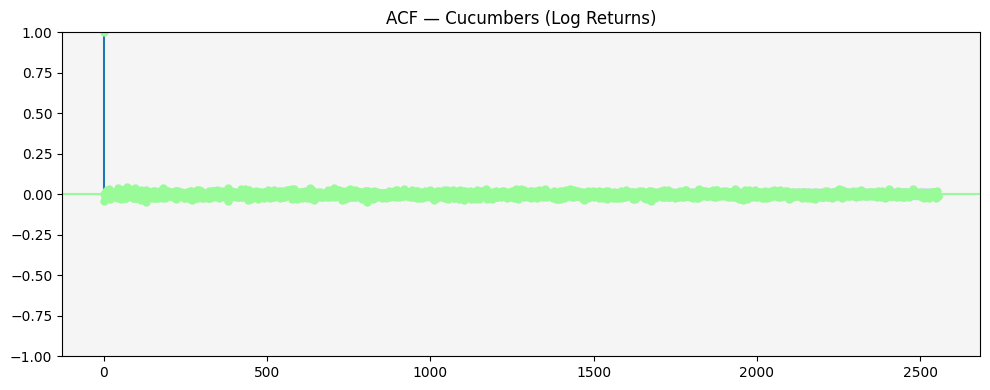

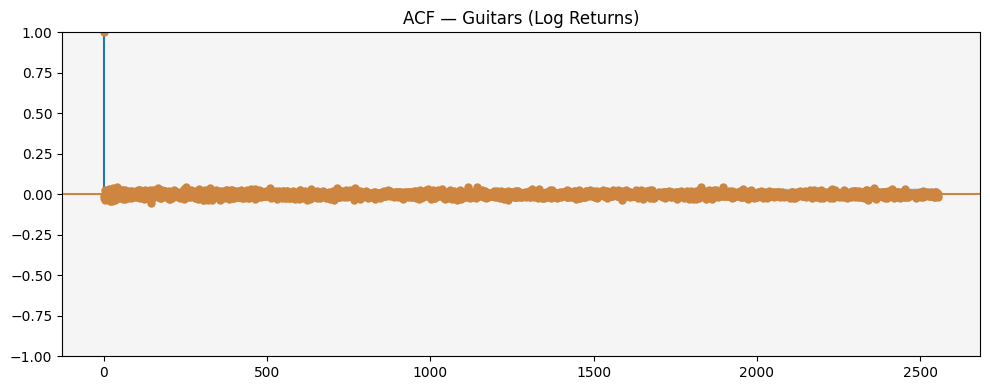

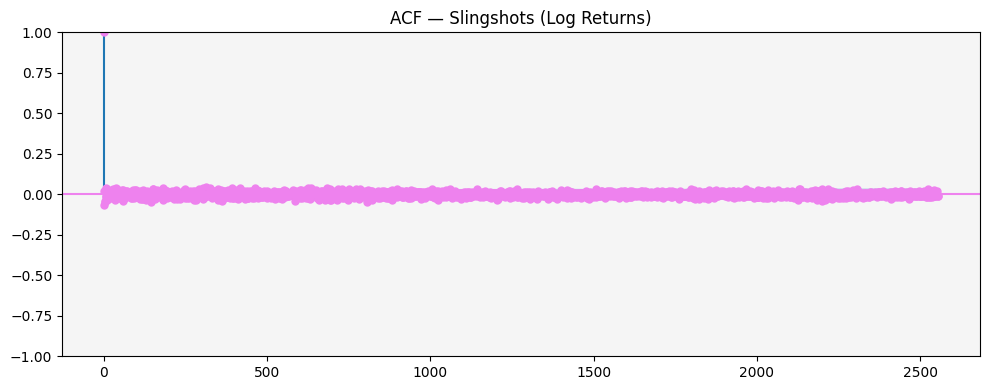

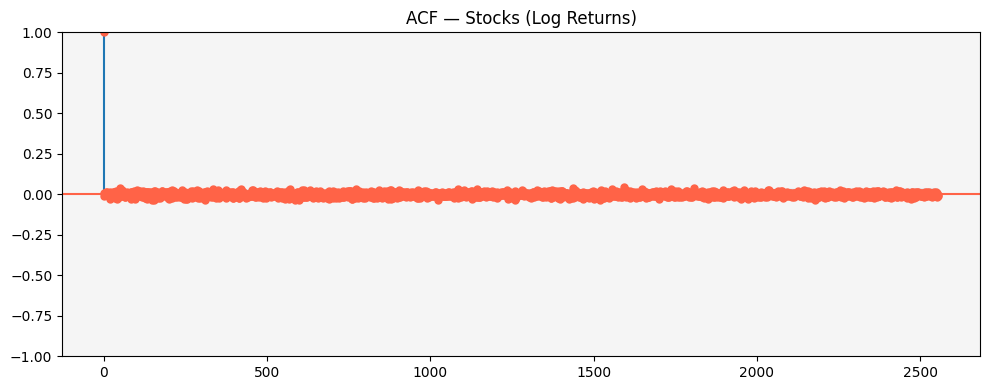

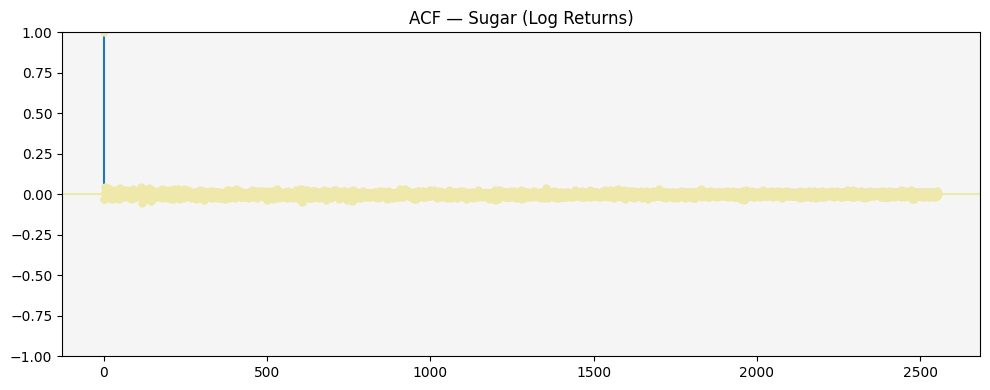

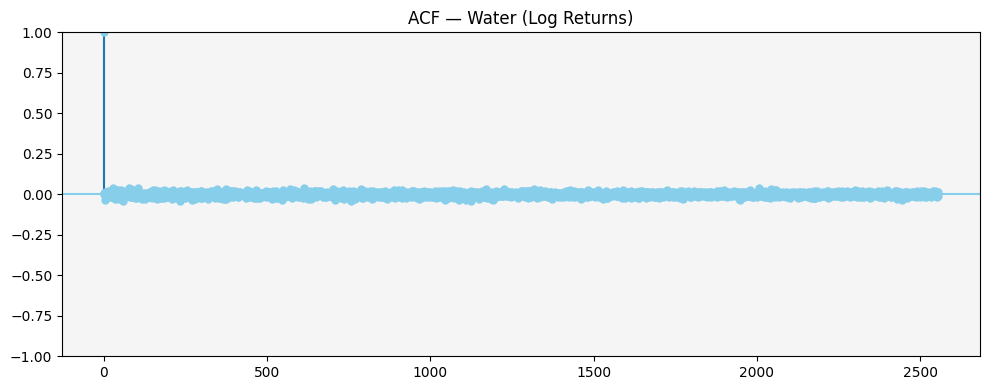

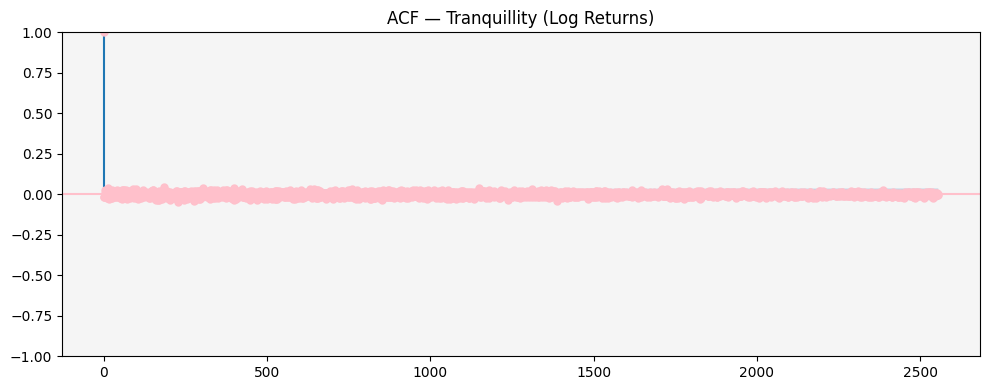

In [121]:

# Generate ACF plots for each category
for column, color in colours.items():
    series = df[column].dropna()
    
    # Log returns
    log_return = np.log(series / series.shift(1)).dropna()
    
    fig, ax = plt.subplots(figsize=(10, 4))
    plot_acf(log_return, lags=min(365*7, len(series) // 2), ax=ax, title=f"ACF — {column.capitalize()} (Log Returns)", color=color)
    ax.set_facecolor("whitesmoke")
    plt.tight_layout()
    plt.show()



Analyzing cucumbers...
Tested Period 7 days: Strength = 0.169
Tested Period 30 days: Strength = 0.167
Tested Period 90 days: Strength = 0.176
Tested Period 180 days: Strength = 0.229
Tested Period 365 days: Strength = 0.257
✅ Best Period: 365 days (Strength: 0.257)

Analyzing guitars...
Tested Period 7 days: Strength = 0.167
Tested Period 30 days: Strength = 0.175
Tested Period 90 days: Strength = 0.149
Tested Period 180 days: Strength = 0.114
Tested Period 365 days: Strength = 0.146
✅ Best Period: 30 days (Strength: 0.175)

Analyzing slingshots...
Tested Period 7 days: Strength = 0.170
Tested Period 30 days: Strength = 0.169
Tested Period 90 days: Strength = 0.128
Tested Period 180 days: Strength = 0.178
Tested Period 365 days: Strength = 0.198
✅ Best Period: 365 days (Strength: 0.198)

Analyzing stocks...
Tested Period 7 days: Strength = 0.126
Tested Period 30 days: Strength = 0.194
Tested Period 90 days: Strength = 0.201
Tested Period 180 days: Strength = 0.208
Tested Period 365 da

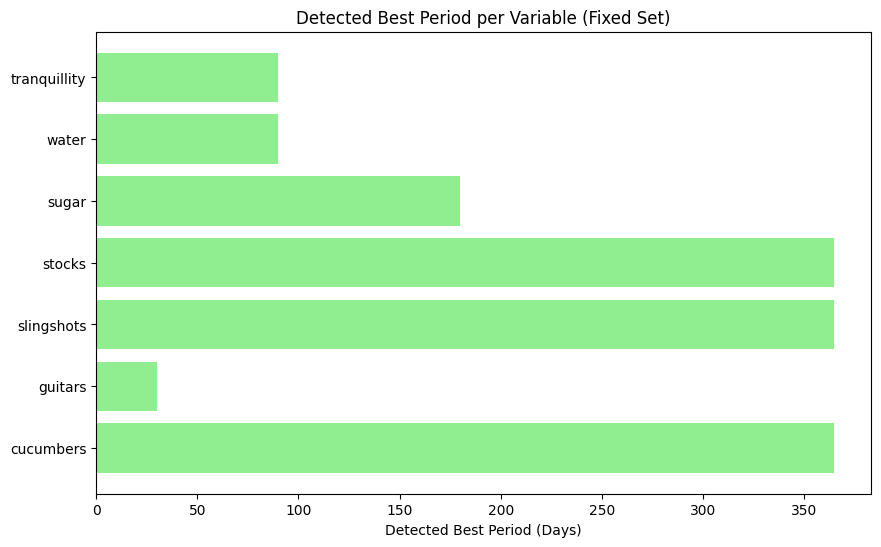

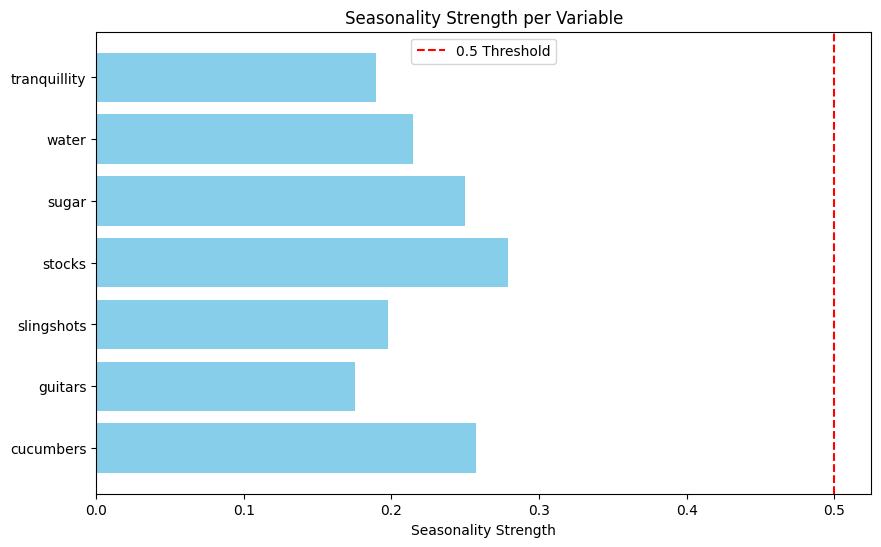

In [135]:
# Target variables
variables = ['cucumbers', 'guitars', 'slingshots', 'stocks', 'sugar', 'water', 'tranquillity']

# Fixed periods to test
periods_to_test = [7, 30, 90, 180, 365]

# --- Helper Function ---

def calculate_seasonality_strength(result):
    """Strength = variance of seasonal / (variance of seasonal + variance of residual)"""
    seasonal_var = np.var(result.seasonal)
    residual_var = np.var(result.resid)
    return seasonal_var / (seasonal_var + residual_var)

def best_fixed_period(series, periods_to_test):
    """Find best period among a fixed set."""
    best_strength = -np.inf
    best_period = None
    
    for test_period in periods_to_test:
        if test_period >= len(series.dropna()) // 2:
            continue  # Skip if period is too long for data

        try:
            stl = STL(series, period=test_period, robust=True)
            result = stl.fit()
            strength = calculate_seasonality_strength(result)
            print(f"Tested Period {test_period} days: Strength = {strength:.3f}")
            
            if strength > best_strength:
                best_strength = strength
                best_period = test_period
        except Exception as e:
            print(f"Error testing period {test_period}: {e}")
            continue

    return best_period, best_strength

# --- Analysis ---

best_periods = {}
seasonality_strengths = {}

for var in variables:
    print(f"\nAnalyzing {var}...")
    series = df[var].dropna()
    
    best_period, best_strength = best_fixed_period(series, periods_to_test)
    
    if best_period is None:
        print(f"⚠️ No good period found for {var}. Skipping.")
        continue

    best_periods[var] = best_period
    seasonality_strengths[var] = best_strength
    print(f"✅ Best Period: {best_period} days (Strength: {best_strength:.3f})")

# --- Results ---

# Plot best periods
plt.figure(figsize=(10, 6))
plt.barh(list(best_periods.keys()), list(best_periods.values()), color='lightgreen')
plt.xlabel("Detected Best Period (Days)")
plt.title("Detected Best Period per Variable (Fixed Set)")
plt.show()

# Plot seasonality strength
plt.figure(figsize=(10, 6))
plt.barh(list(seasonality_strengths.keys()), list(seasonality_strengths.values()), color='skyblue')
plt.xlabel("Seasonality Strength")
plt.title("Seasonality Strength per Variable")
plt.axvline(0.5, color='red', linestyle='--', label='0.5 Threshold')
plt.legend()
plt.show()



 ANALYSIS: CUCUMBERS


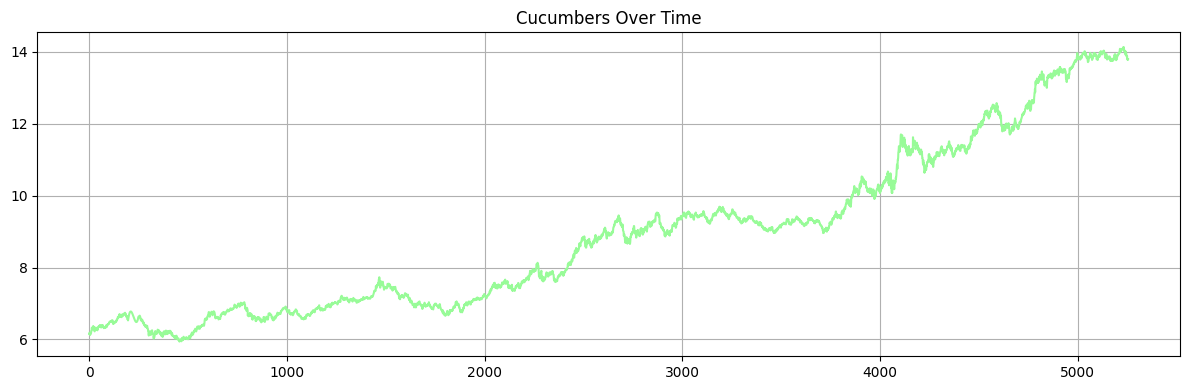

ADF p-value: 0.9929 → Non-Stationary
Seasonality Detected at Period(s):
 - 7 days (seasonal/residual var ratio ≈ 0.20)
 - 30 days (seasonal/residual var ratio ≈ 0.20)
 - 90 days (seasonal/residual var ratio ≈ 0.21)
 - 180 days (seasonal/residual var ratio ≈ 0.26)
 - 365 days (seasonal/residual var ratio ≈ 0.32)


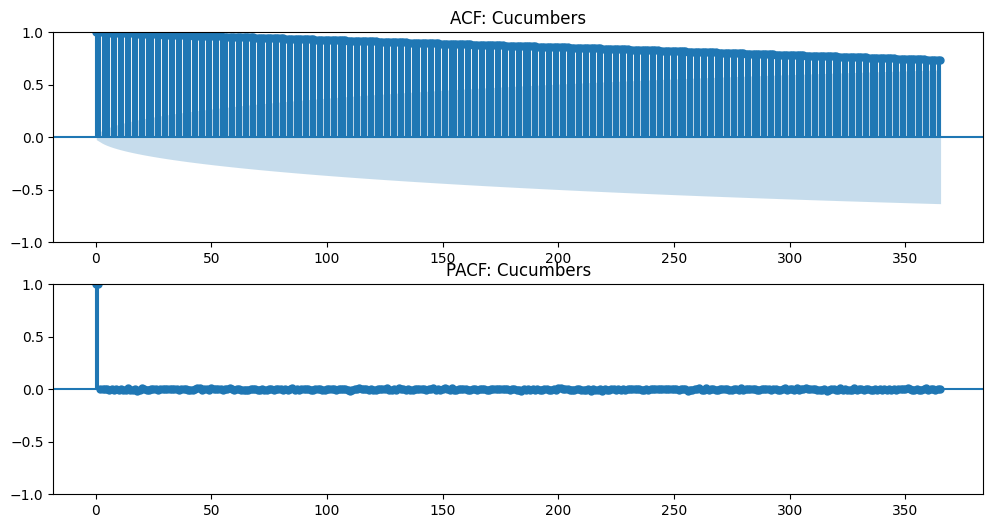

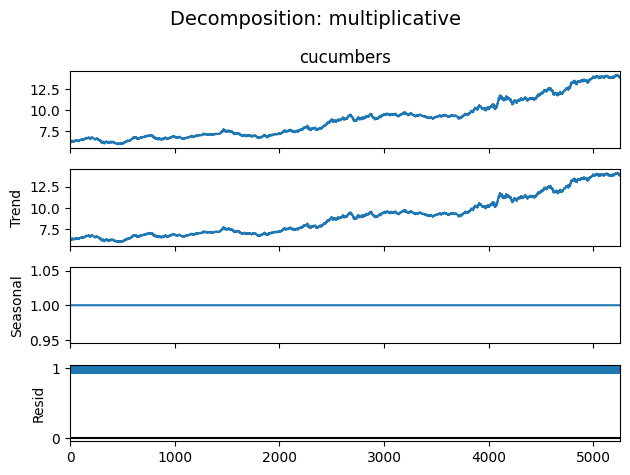

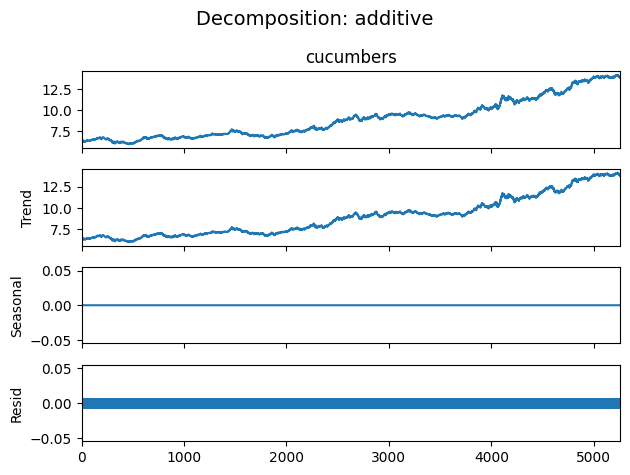

<Figure size 640x480 with 0 Axes>


 ANALYSIS: GUITARS


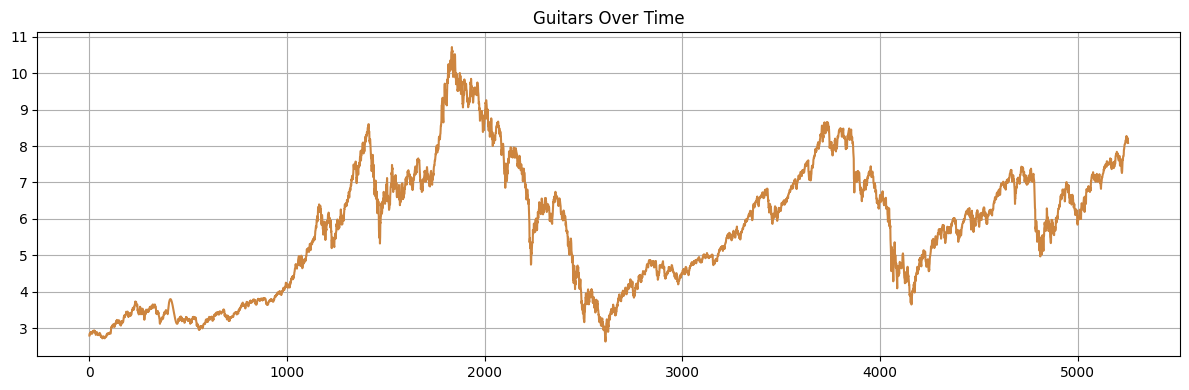

ADF p-value: 0.2692 → Non-Stationary
Seasonality Detected at Period(s):
 - 7 days (seasonal/residual var ratio ≈ 0.21)
 - 30 days (seasonal/residual var ratio ≈ 0.23)
 - 90 days (seasonal/residual var ratio ≈ 0.18)
 - 180 days (seasonal/residual var ratio ≈ 0.15)
 - 365 days (seasonal/residual var ratio ≈ 0.15)


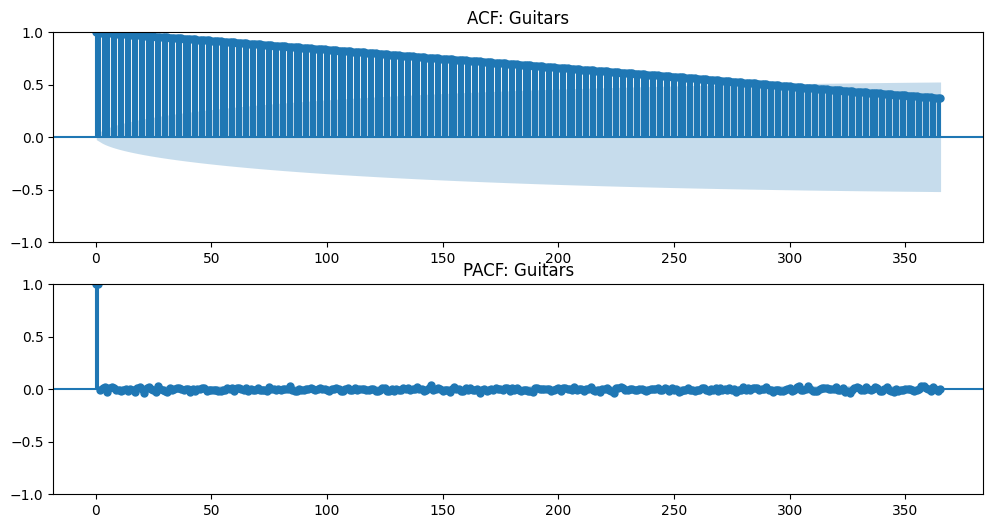

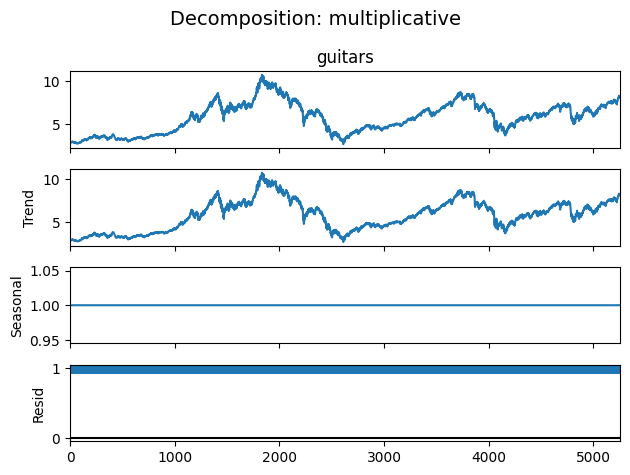

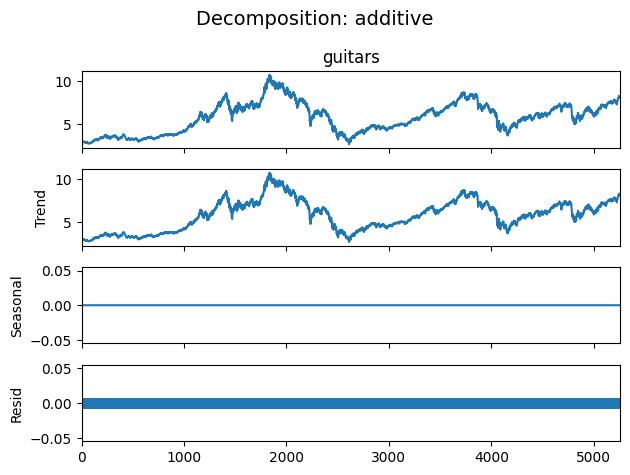

<Figure size 640x480 with 0 Axes>


 ANALYSIS: SLINGSHOTS


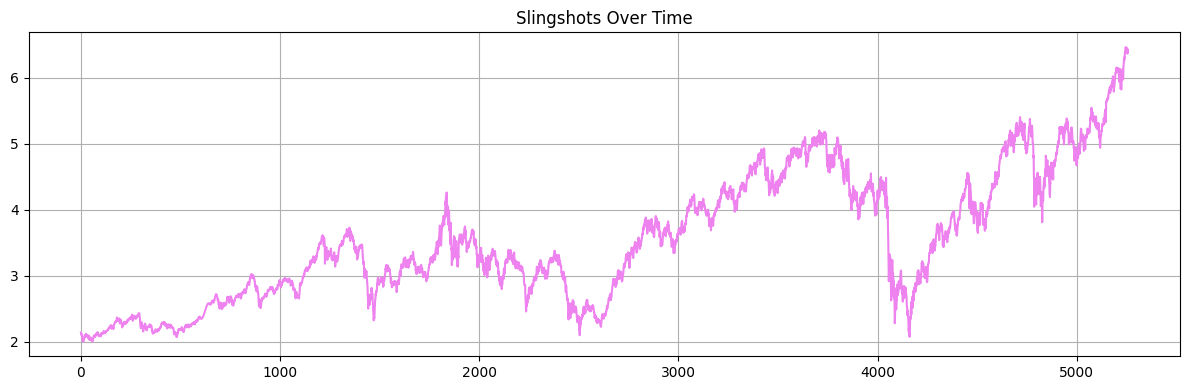

ADF p-value: 0.7860 → Non-Stationary
Seasonality Detected at Period(s):
 - 7 days (seasonal/residual var ratio ≈ 0.20)
 - 30 days (seasonal/residual var ratio ≈ 0.22)
 - 90 days (seasonal/residual var ratio ≈ 0.17)
 - 180 days (seasonal/residual var ratio ≈ 0.24)
 - 365 days (seasonal/residual var ratio ≈ 0.24)


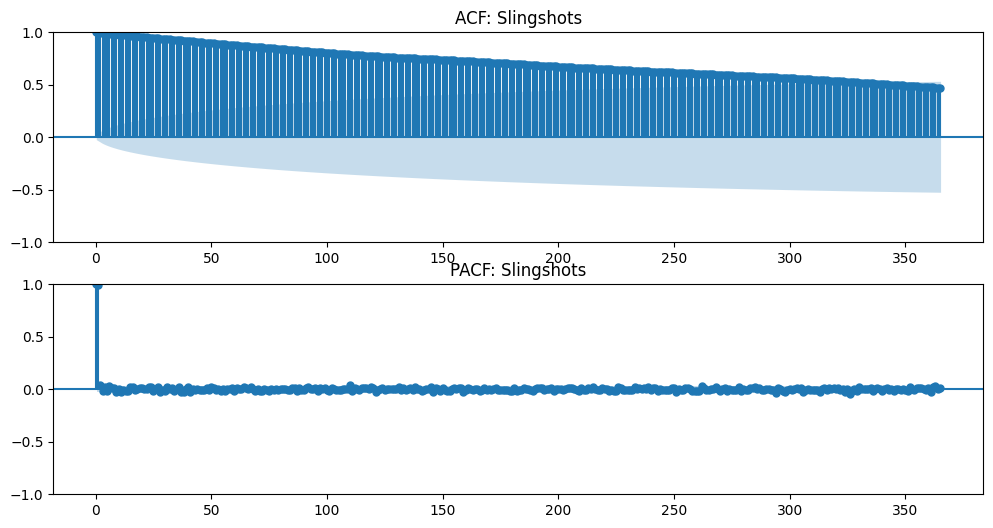

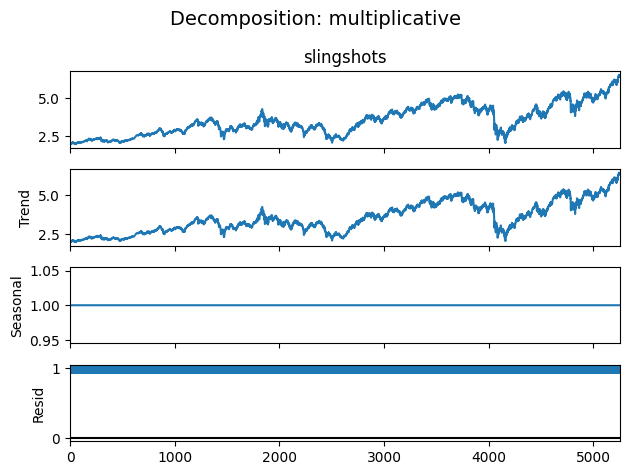

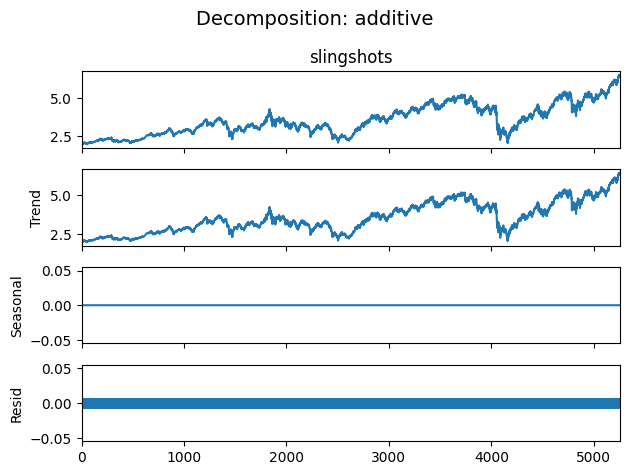

<Figure size 640x480 with 0 Axes>


 ANALYSIS: STOCKS


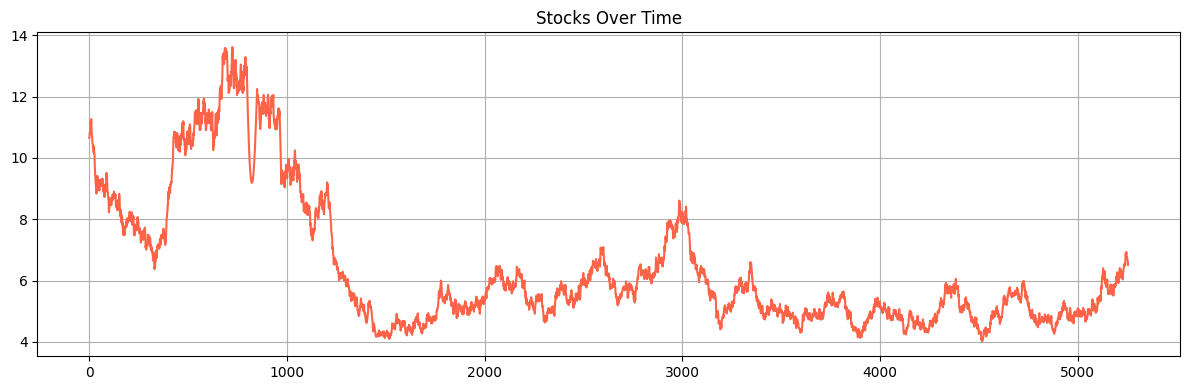

ADF p-value: 0.1715 → Non-Stationary
Seasonality Detected at Period(s):
 - 7 days (seasonal/residual var ratio ≈ 0.19)
 - 30 days (seasonal/residual var ratio ≈ 0.23)
 - 90 days (seasonal/residual var ratio ≈ 0.20)
 - 180 days (seasonal/residual var ratio ≈ 0.25)
 - 365 days (seasonal/residual var ratio ≈ 0.58)


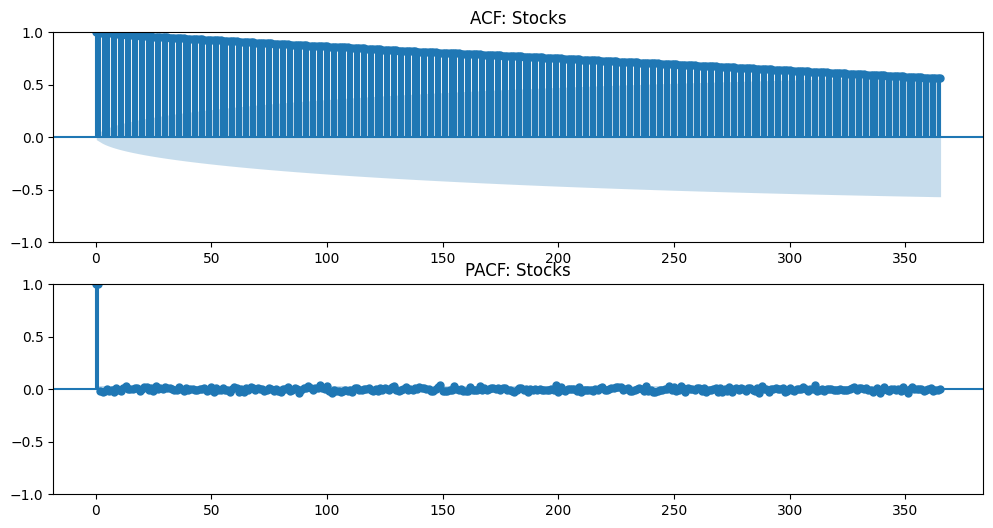

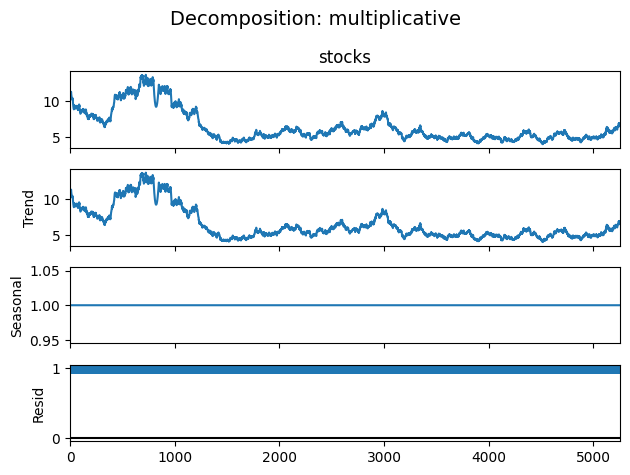

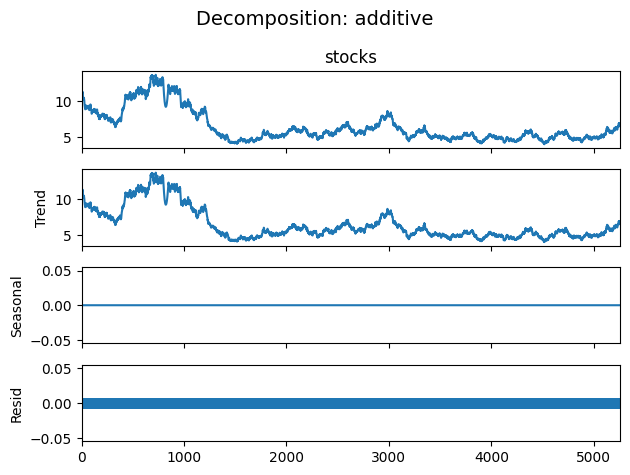

<Figure size 640x480 with 0 Axes>


 ANALYSIS: SUGAR


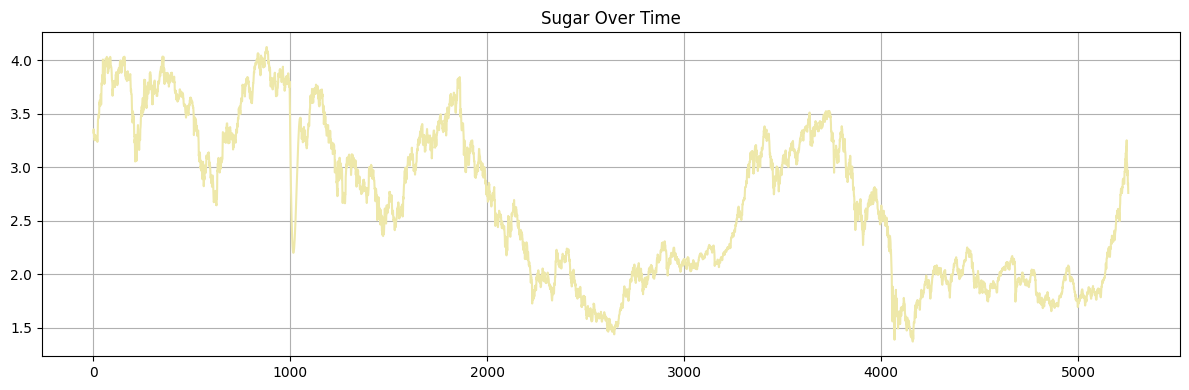

ADF p-value: 0.1517 → Non-Stationary
Seasonality Detected at Period(s):
 - 7 days (seasonal/residual var ratio ≈ 0.18)
 - 30 days (seasonal/residual var ratio ≈ 0.16)
 - 90 days (seasonal/residual var ratio ≈ 0.22)
 - 180 days (seasonal/residual var ratio ≈ 0.24)
 - 365 days (seasonal/residual var ratio ≈ 0.27)


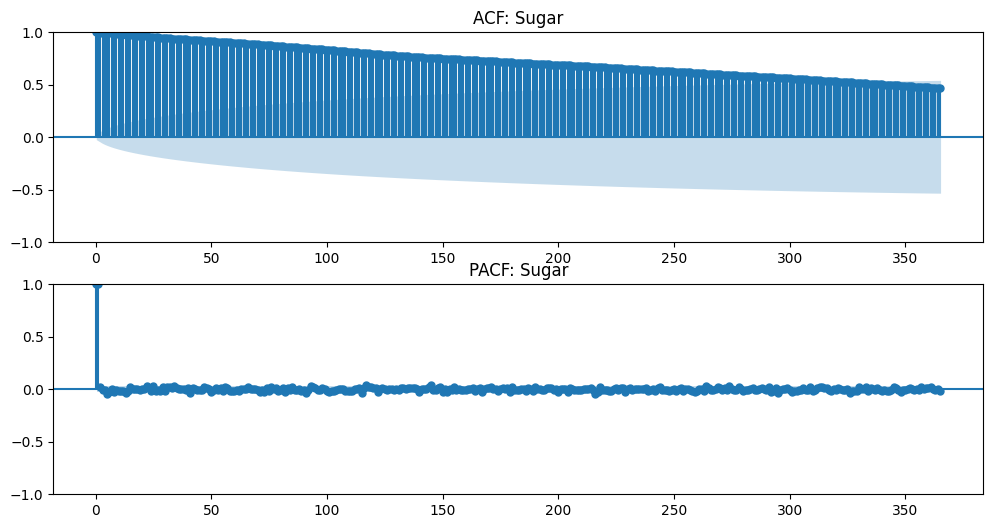

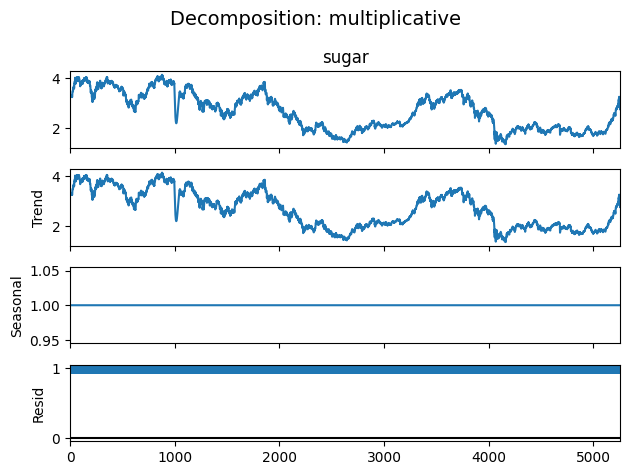

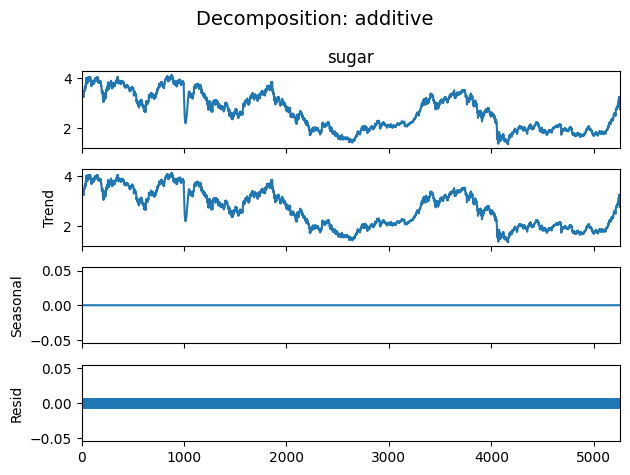

<Figure size 640x480 with 0 Axes>


 ANALYSIS: WATER


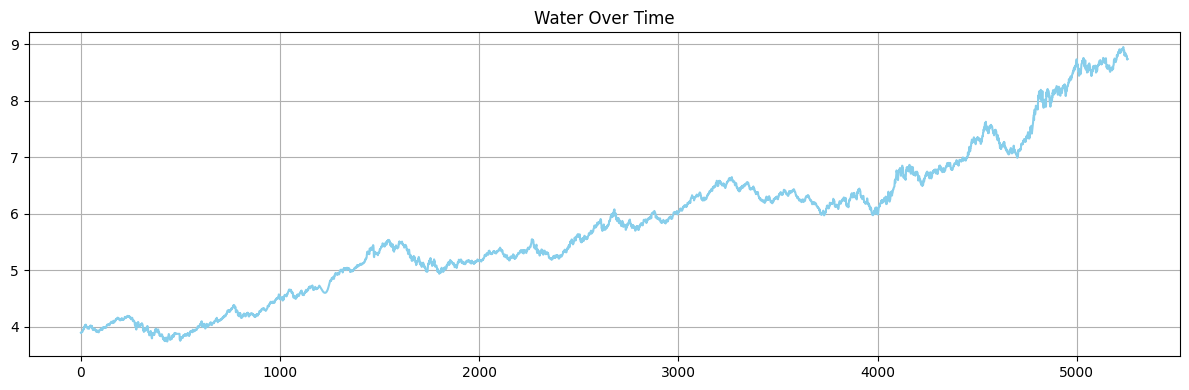

ADF p-value: 0.9912 → Non-Stationary
Seasonality Detected at Period(s):
 - 7 days (seasonal/residual var ratio ≈ 0.17)
 - 30 days (seasonal/residual var ratio ≈ 0.24)
 - 90 days (seasonal/residual var ratio ≈ 0.27)
 - 180 days (seasonal/residual var ratio ≈ 0.24)
 - 365 days (seasonal/residual var ratio ≈ 0.18)


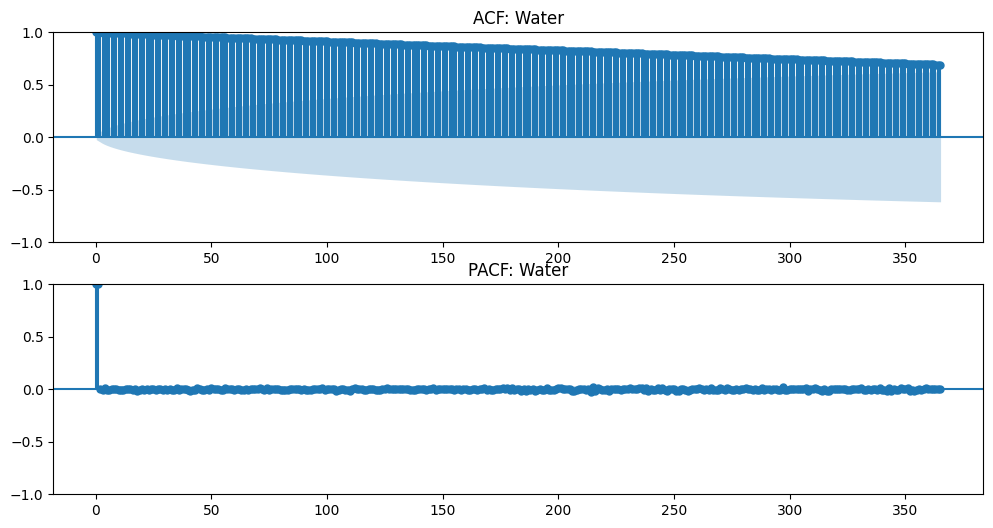

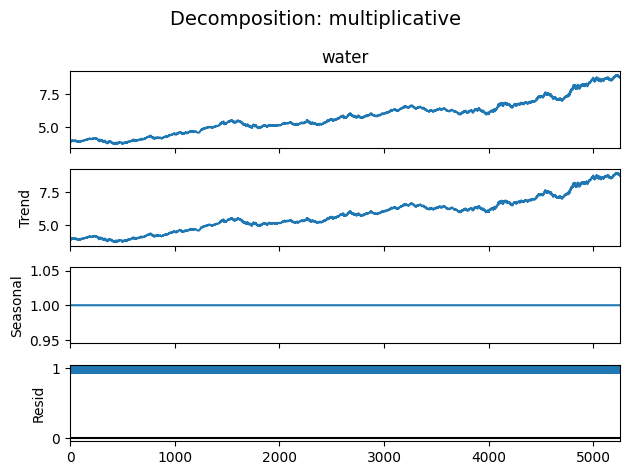

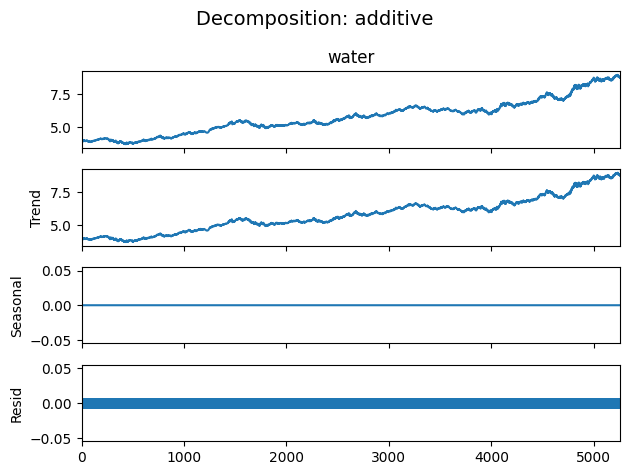

<Figure size 640x480 with 0 Axes>


 ANALYSIS: TRANQUILLITY


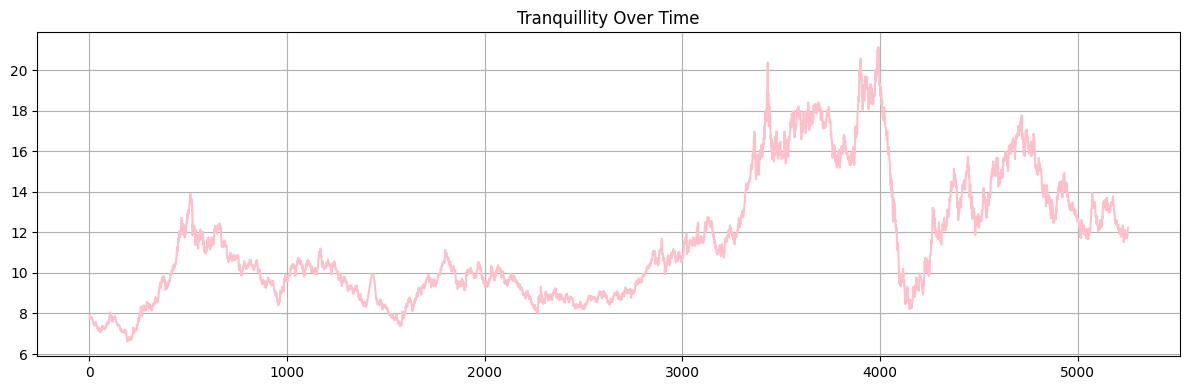

ADF p-value: 0.1855 → Non-Stationary
Seasonality Detected at Period(s):
 - 7 days (seasonal/residual var ratio ≈ 0.19)
 - 30 days (seasonal/residual var ratio ≈ 0.21)
 - 90 days (seasonal/residual var ratio ≈ 0.26)
 - 180 days (seasonal/residual var ratio ≈ 0.15)
 - 365 days (seasonal/residual var ratio ≈ 0.15)


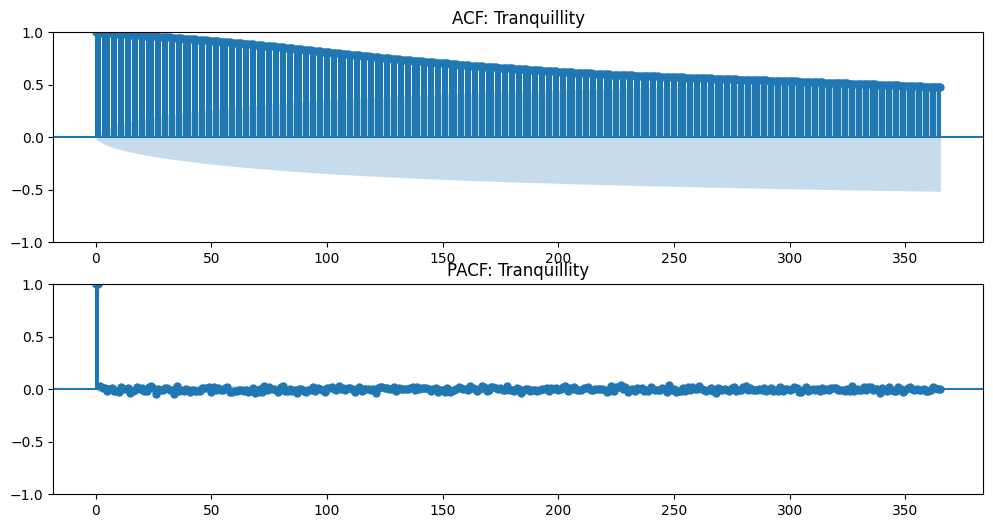

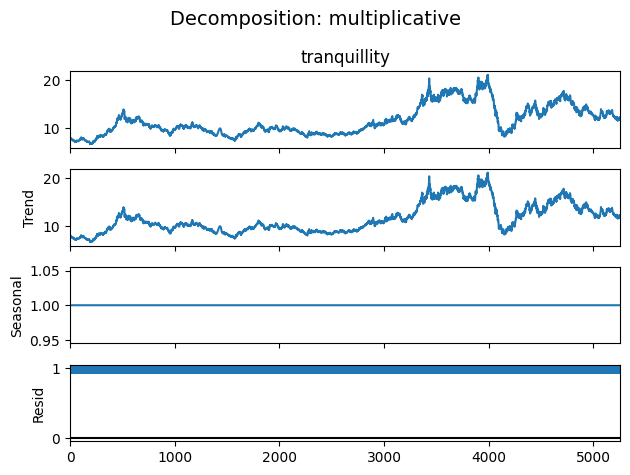

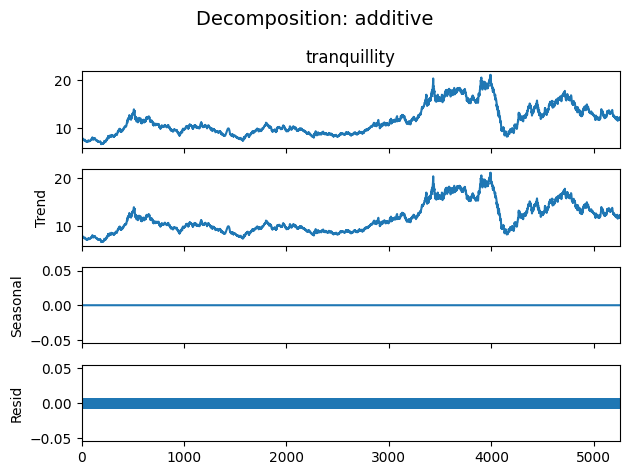

<Figure size 640x480 with 0 Axes>

In [122]:
# Candidate seasonal periods (in days)
candidate_periods = [7, 30, 90, 180, 365]

# Loop through all series
for col, color in colours.items():
    series = df[col].dropna()

    print(f"\n{'='*50}\n ANALYSIS: {col.upper()}\n{'='*50}")

    #Plot
    plt.figure(figsize=(12, 4))
    plt.plot(series, color=color)
    plt.title(f"{col.capitalize()} Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #ADF test for stationarity
    adf_result = adfuller(series)
    print(f"ADF p-value: {adf_result[1]:.4f} → {'Stationary' if adf_result[1] < 0.05 else 'Non-Stationary'}")

    # Smart Seasonality Detection
    detected_periods = []

    for period in candidate_periods:
        stl = STL(series, period=period, robust=True)
        result = stl.fit()
        seasonal_var = np.var(result.seasonal)
        resid_var = np.var(result.resid)

        ratio = seasonal_var / (resid_var + 1e-5)
        if ratio > 0.1:  # threshold ?
            detected_periods.append((period, ratio))

    if detected_periods:
        print("Seasonality Detected at Period(s):")
        for p, r in detected_periods:
            print(f" - {p} days (seasonal/residual var ratio ≈ {r:.2f})")
    else:
        print("No strong seasonality detected.")

    # ACF & PACF
    fig, axs = plt.subplots(2, 1, figsize=(12, 6))
    plot_acf(series, lags=365, ax=axs[0])
    axs[0].set_title(f'ACF: {col.capitalize()}')

    plot_pacf(series, lags=365, ax=axs[1])
    axs[1].set_title(f'PACF: {col.capitalize()}')
    
    # Decomposition multiplicative
    decomp = seasonal_decompose(series, model='multiplicative', period=1, extrapolate_trend='freq')
    decomp.plot()
    plt.suptitle(f'Decomposition: multiplicative', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Decomposition additive
    decomp = seasonal_decompose(series, model='additive', period=1, extrapolate_trend='freq')
    decomp.plot()
    plt.suptitle(f'Decomposition: additive', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    
    # Check if seasonal component has significant variation
    seasonal_std = decomp.seasonal.std()
    is_seasonal_from_decomp = seasonal_std > 0.1  # threshold can be adjusted

    plt.tight_layout()
    plt.show()


In [55]:
trends = {}
seasonals = {}
residuals = {}

for column, color in colours.items():
    series = df[column].dropna()
    # Decompose with extrapolated trend
    result = seasonal_decompose(series, model='multiplicative', period=365, extrapolate_trend='freq')

    trends[column] = result.trend
    seasonals[column] = result.seasonal
    residuals[column] = result.resid

# Convert to DataFrames
trend_df = pd.DataFrame(trends)
seasonal_df = pd.DataFrame(seasonals)
resid_df = pd.DataFrame(residuals)

In [56]:
trend_df.head()

cucumbers   guitars  slingshots    stocks     sugar     water  tranquillity
0   6.254409  3.285182    2.156166  6.064055  4.046958  4.087077      5.387819
1   6.254574  3.285241    2.156458  6.071897  4.045737  4.086727      5.399256
2   6.254739  3.285301    2.156750  6.079739  4.044515  4.086378      5.410693
3   6.254904  3.285361    2.157042  6.087581  4.043294  4.086028      5.422129
4   6.255069  3.285420    2.157334  6.095423  4.042072  4.085678      5.433566

In [57]:
seasonal_df.head()

cucumbers   guitars  slingshots    stocks     sugar     water  tranquillity
0   0.998327  0.966780    0.966747  1.059370  0.987324  0.997634      1.028054
1   0.998789  0.967969    0.966699  1.062803  0.989547  0.997685      1.029812
2   0.999750  0.966413    0.970465  1.061993  0.997076  0.998989      1.029974
3   0.999941  0.968365    0.970328  1.061291  0.992048  0.998295      1.030426
4   0.998819  0.965252    0.973158  1.060415  0.990447  0.999135      1.030629

In [58]:
resid_df.head()

cucumbers   guitars  slingshots    stocks     sugar     water  tranquillity
0   0.985699  0.879800    1.024980  1.658399  0.832127  0.955546      1.400239
1   0.990815  0.894043    1.013881  1.654127  0.838211  0.956502      1.399461
2   0.986481  0.894388    1.011126  1.676162  0.827354  0.954721      1.415106
3   0.984310  0.887458    1.001481  1.679200  0.819785  0.956389      1.404675
4   0.980352  0.893273    1.000182  1.680271  0.825210  0.956692      1.407686

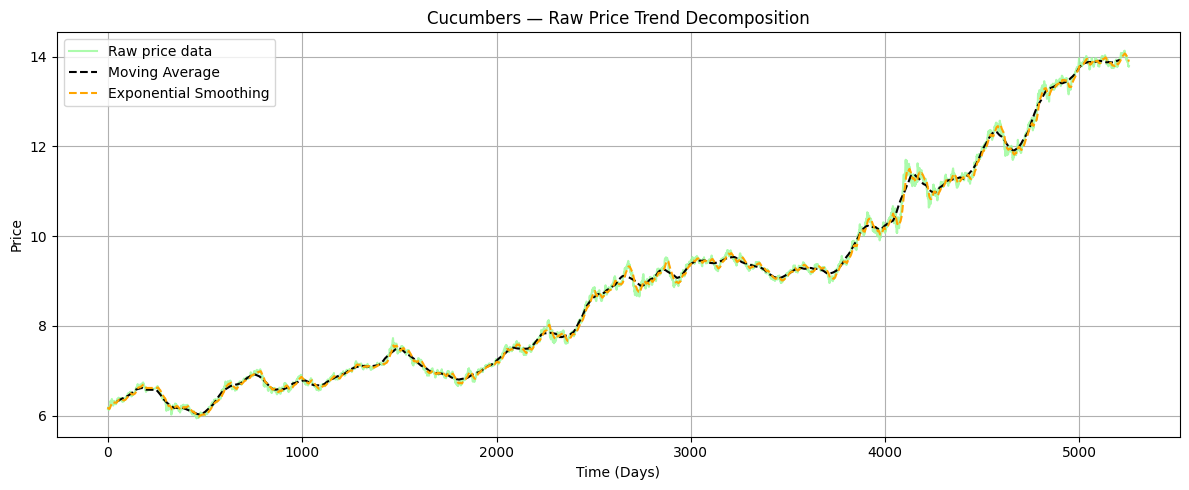

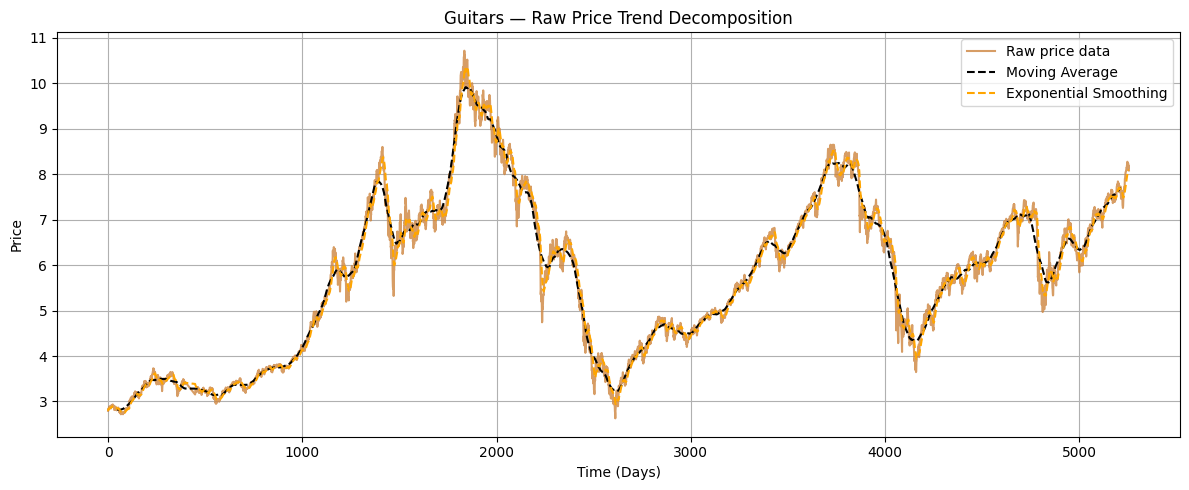

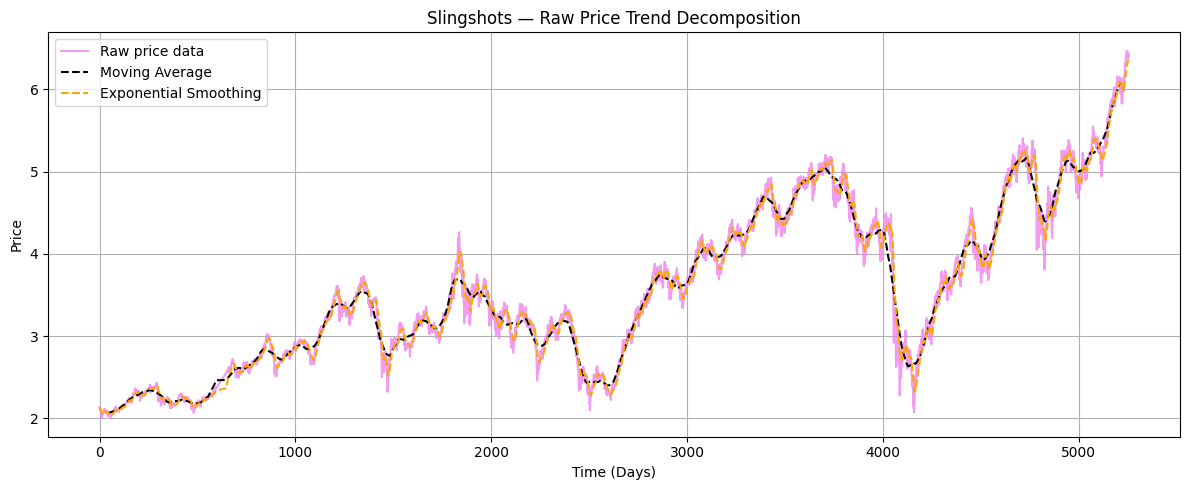

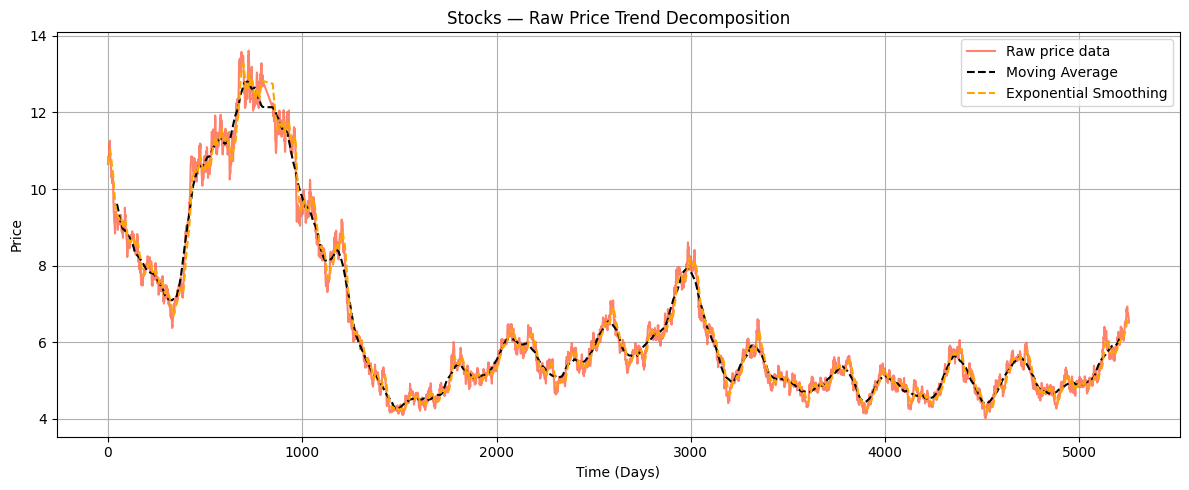

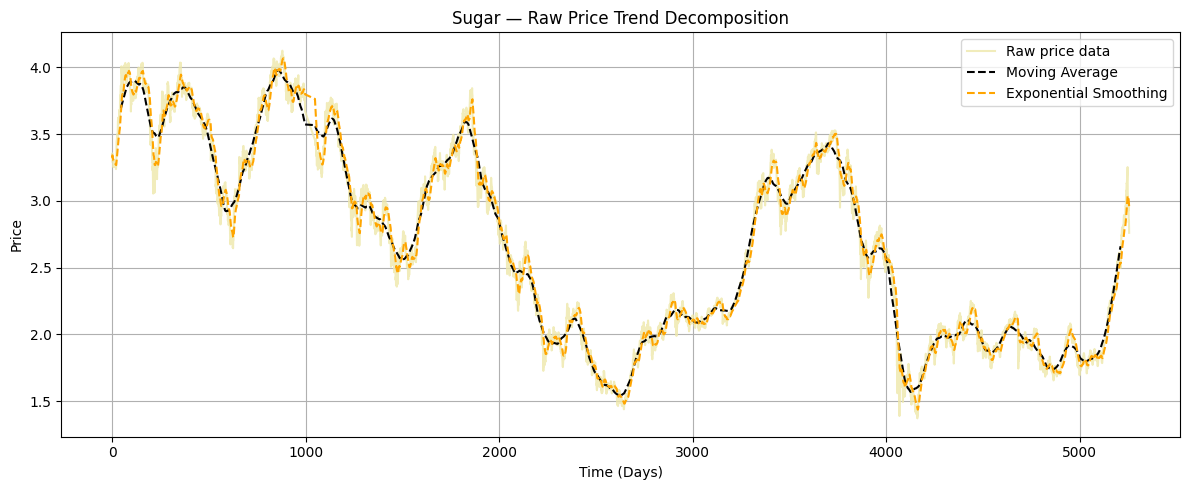

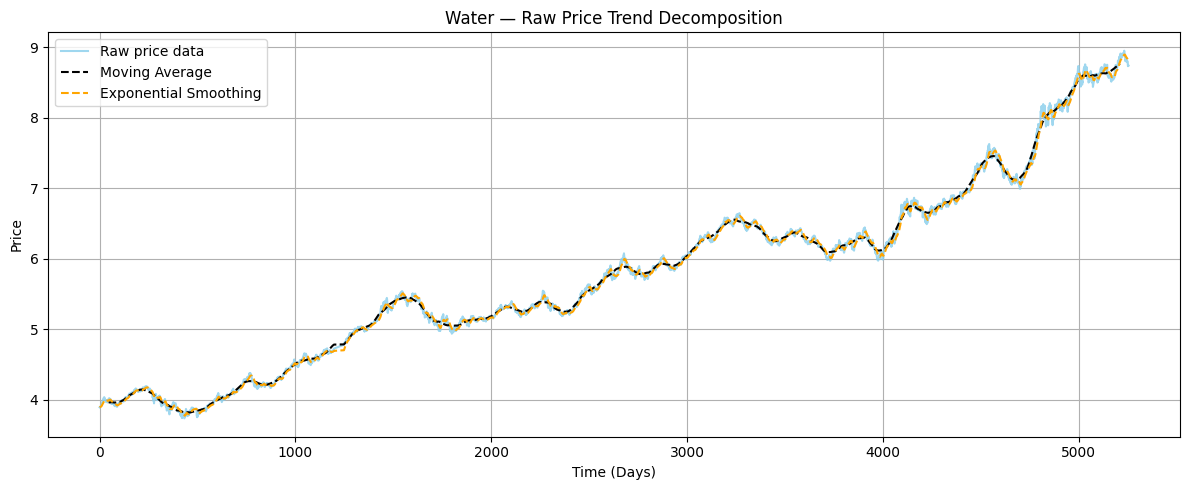

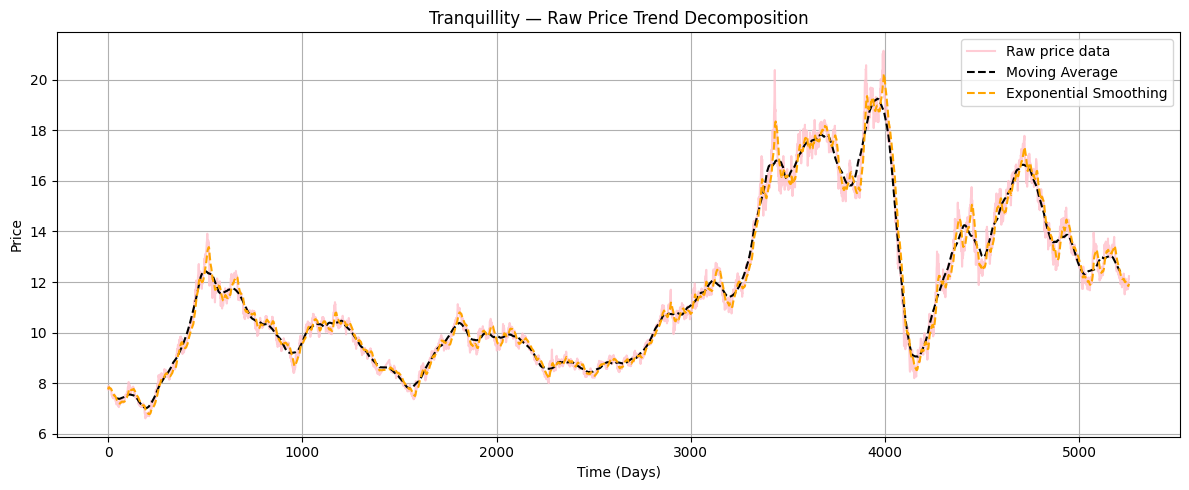

In [59]:
# Parameters
ma_window = 90
ewma_alpha = 0.1
ols_trend_length = 5256

def linear_least_squares_trend(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    beta_1 = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean)**2)
    beta_0 = y_mean - beta_1 * x_mean
    return beta_0 + beta_1 * x

# Loop through each series
for column, color in colours.items():
    series = df[column].dropna()

    # Moving average and exponential smoothing
    ma_trend = series.rolling(window=ma_window, center=True).mean()
    ewma_trend = series.ewm(alpha=ewma_alpha).mean()
    
    # OLS trend on last N points
    if len(series) >= ols_trend_length:
        x = np.arange(ols_trend_length)
        y = series[-ols_trend_length:].values
        trend_values = linear_least_squares_trend(x, y)
        ols_index = series.index[-ols_trend_length:]
    else:
        trend_values = None

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(series.index, series, color=color, alpha=0.8, label='Raw price data')
    plt.plot(series.index, ma_trend, '--', color='black', label='Moving Average')
    plt.plot(series.index, ewma_trend, '--', color='orange', label='Exponential Smoothing')
    
    if trend_values is not None:
        plt.plot(ols_index, trend_values, '--', color='dodgerblue', label='Linear Trend (Least Squares)')

    plt.title(f"{column.capitalize()} — Raw Price Trend Decomposition")
    plt.xlabel("Time (Days)")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


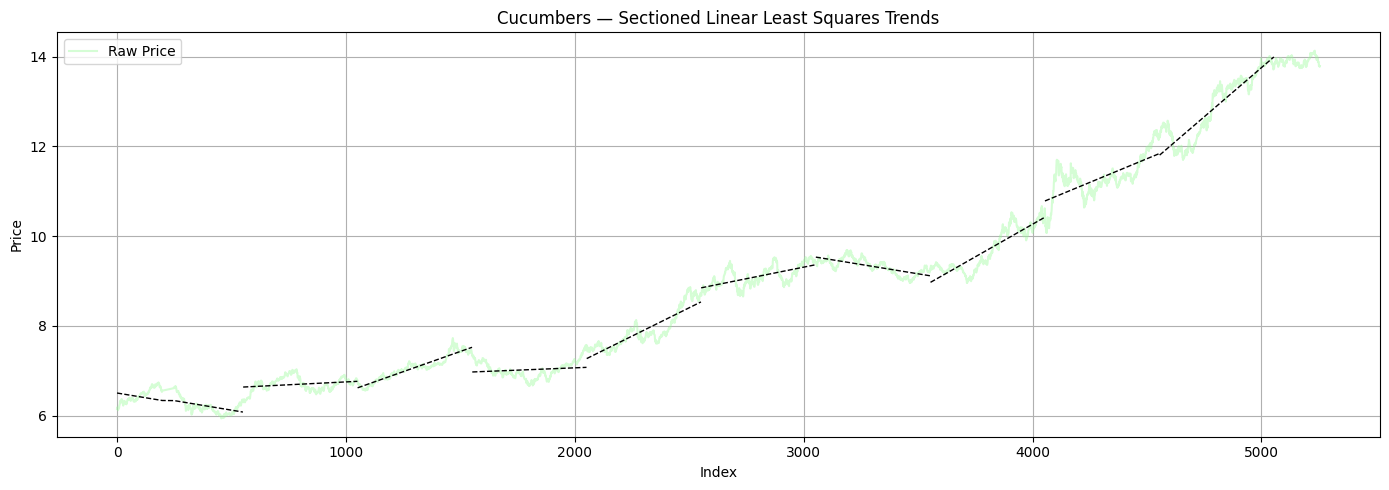

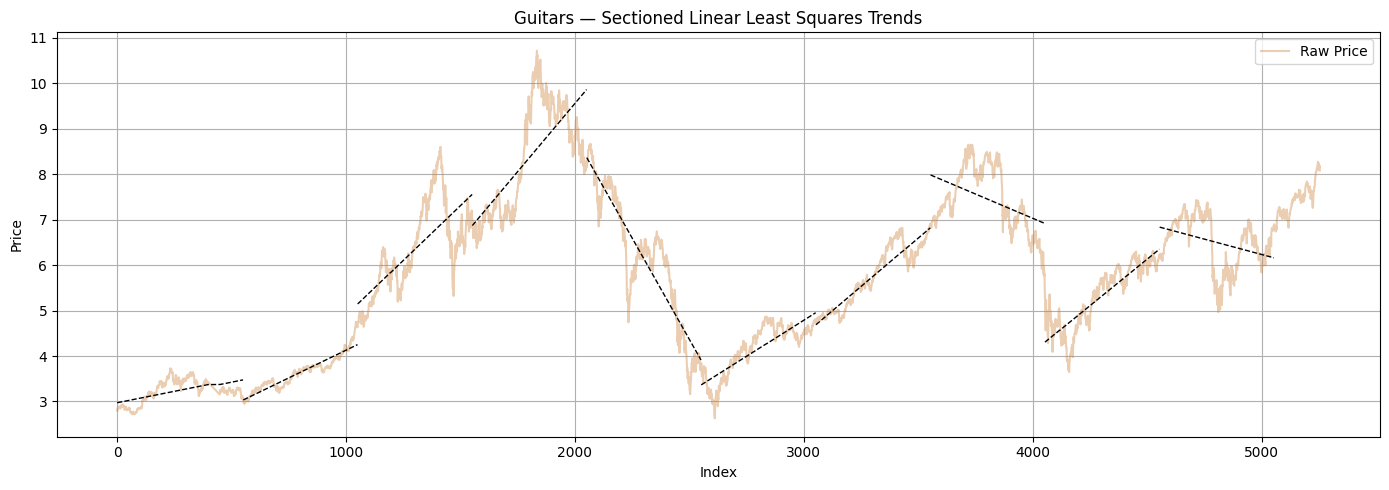

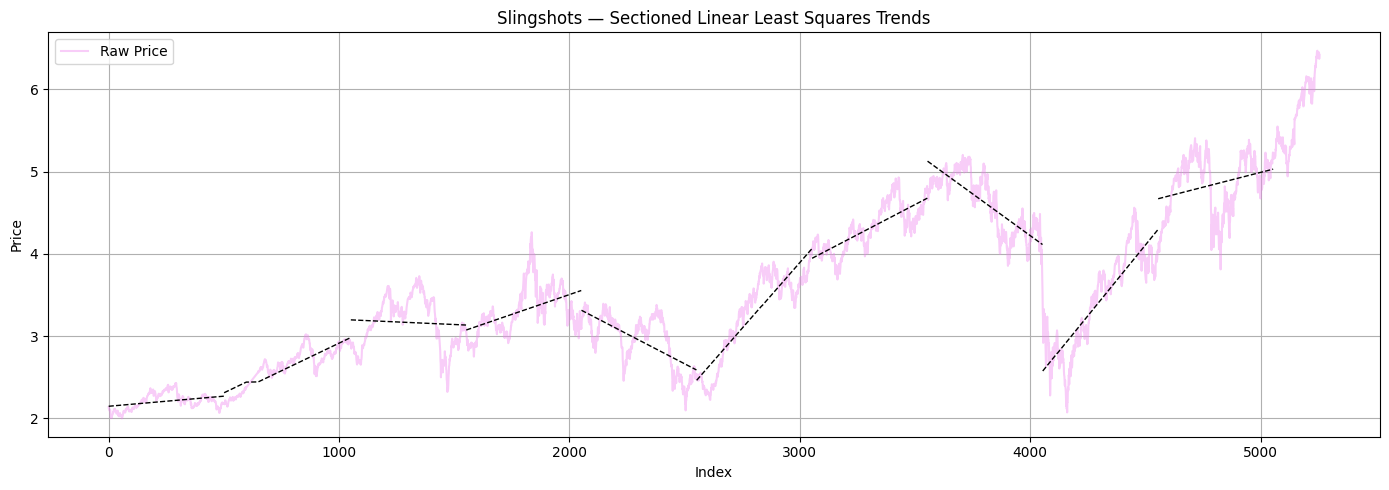

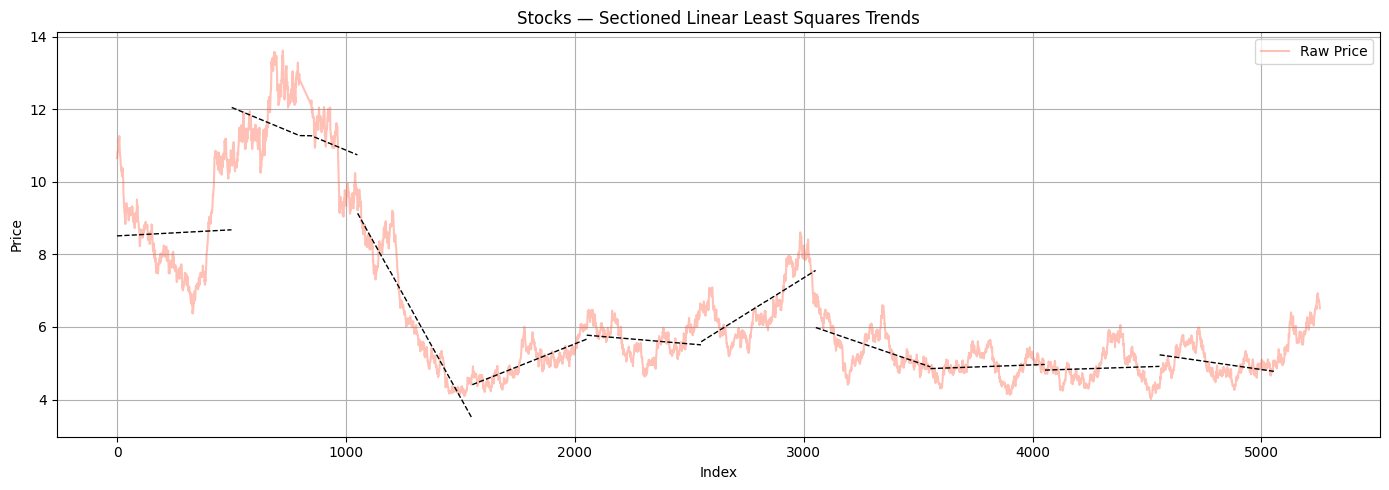

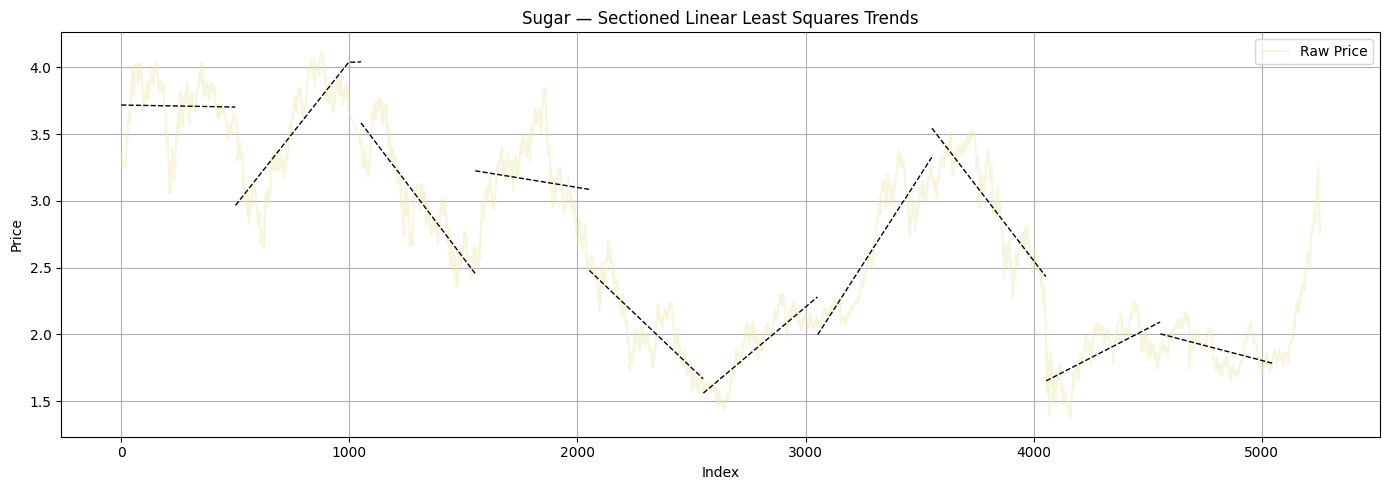

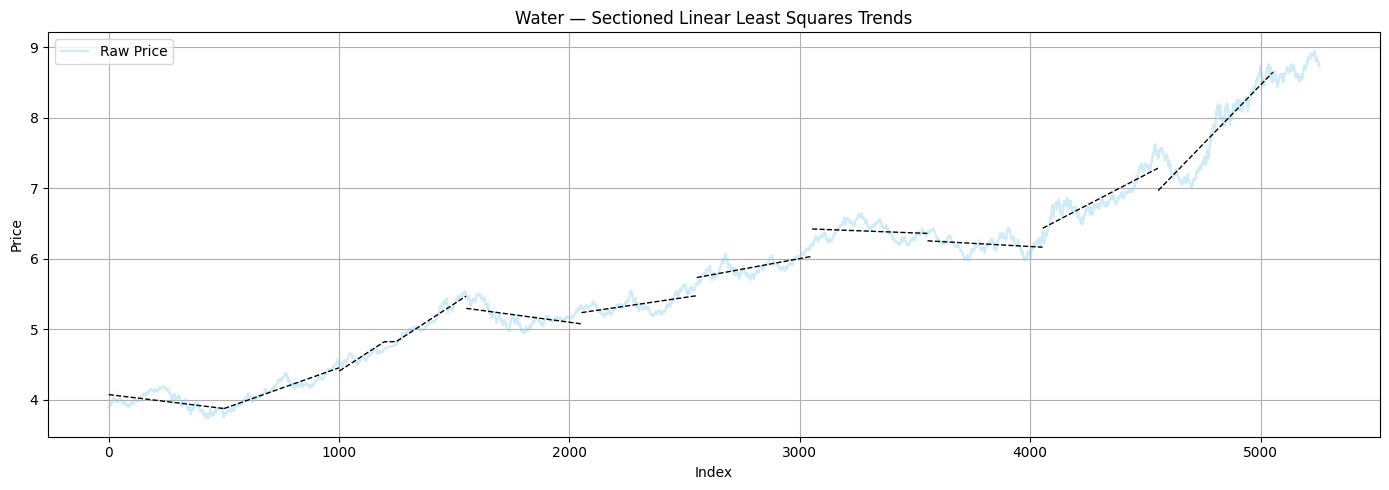

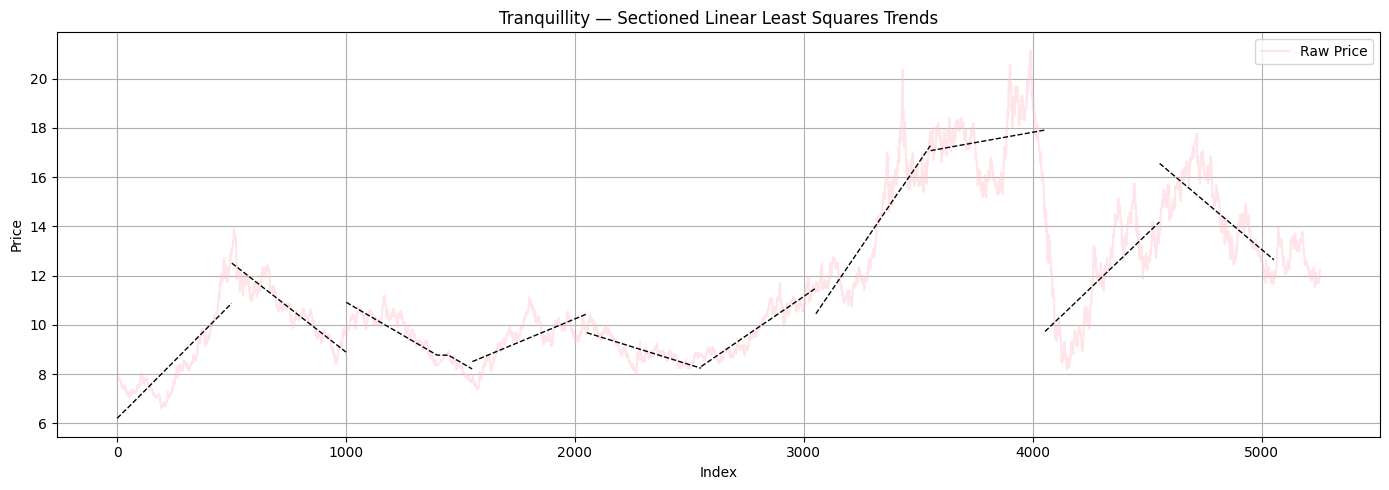

In [60]:
# Segment length
segment_size = 500

# Linear Least Squares
def linear_least_squares(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    beta_1 = np.sum((x - x_mean)*(y - y_mean)) / np.sum((x - x_mean)**2)
    beta_0 = y_mean - beta_1 * x_mean
    return beta_0 + beta_1 * x

# Process each category
for column, color in colours.items():
    series = df[column].dropna()
    if len(series) < segment_size:
        print(f"Skipping {column}: Not enough data for segmentation.")
        continue

    plt.figure(figsize=(14, 5))
    plt.plot(series.index, series.values, label="Raw Price", color=color, alpha=0.4)

    # Break into segments
    num_segments = len(series) // segment_size
    for i in range(num_segments):
        start = i * segment_size
        end = start + segment_size
        segment = series.iloc[start:end]
        if len(segment) < segment_size:
            continue
        x = np.arange(len(segment))
        trend = linear_least_squares(x, segment.values)
        plt.plot(segment.index, trend, color='black', linestyle='--', linewidth=1)

    plt.title(f"{column.capitalize()} — Sectioned Linear Least Squares Trends")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


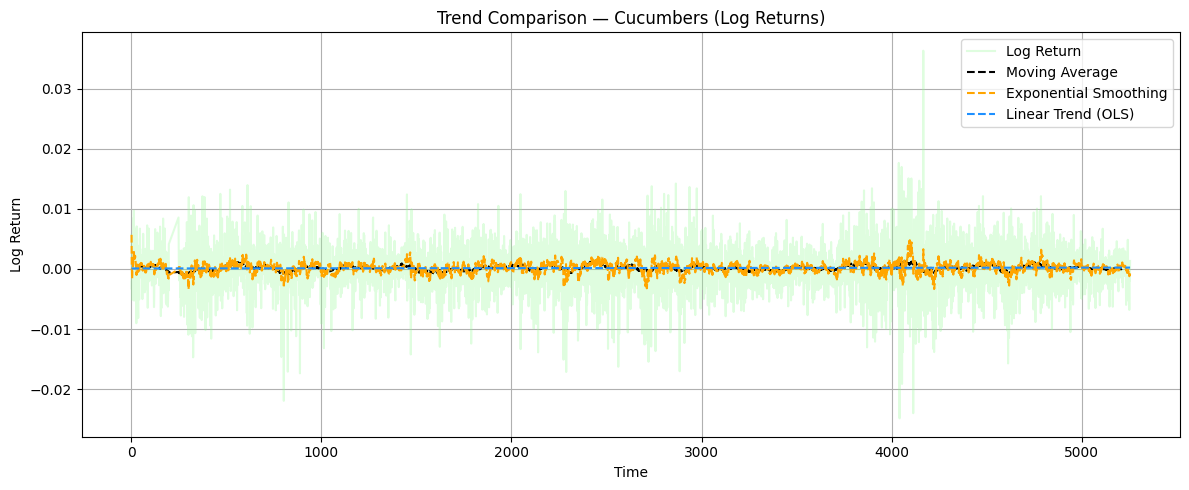

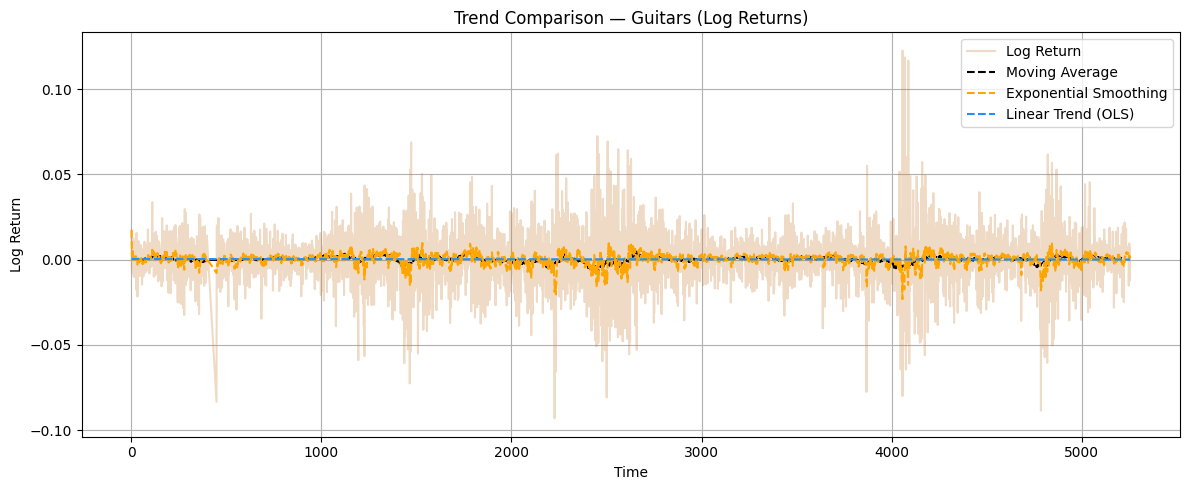

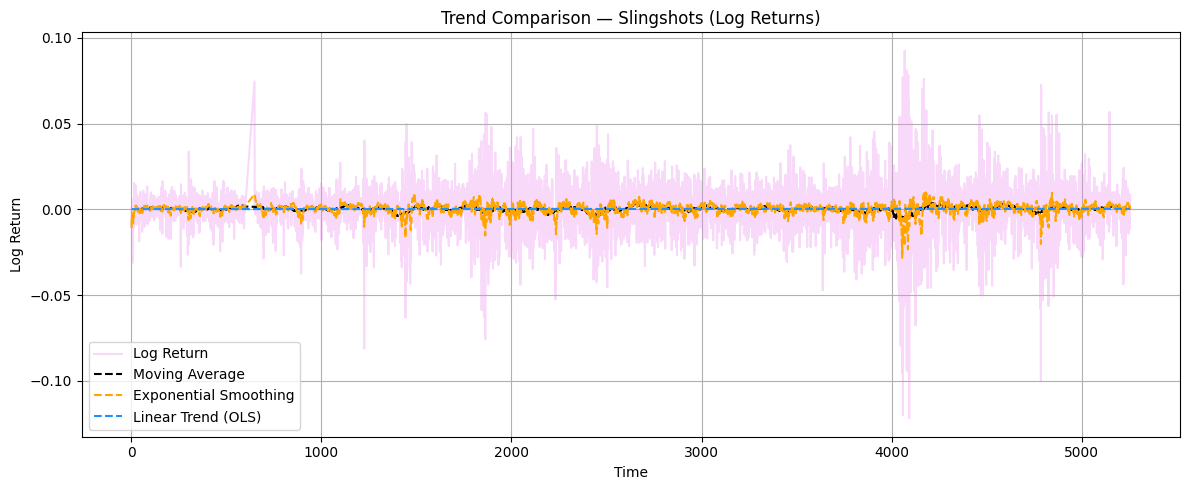

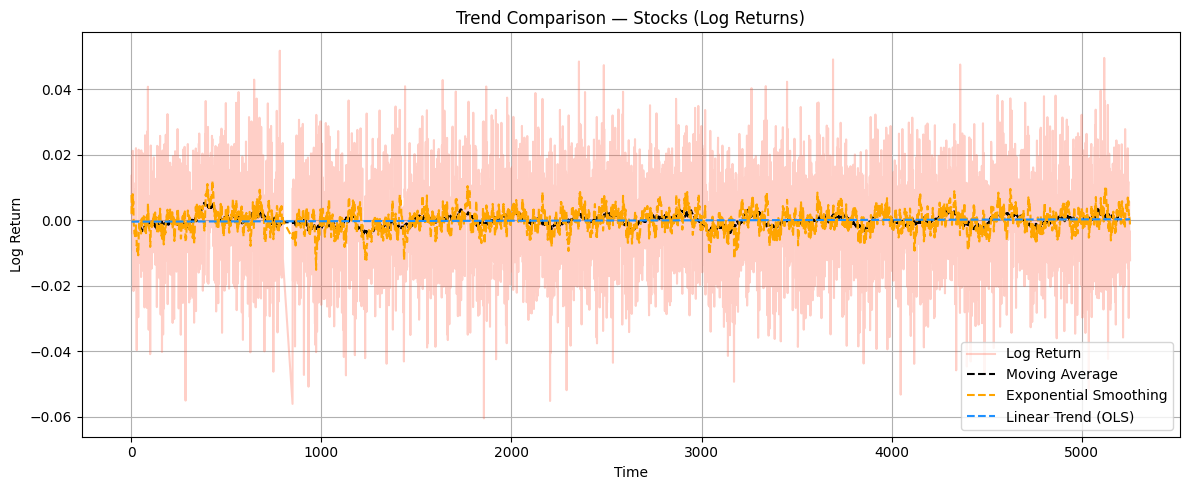

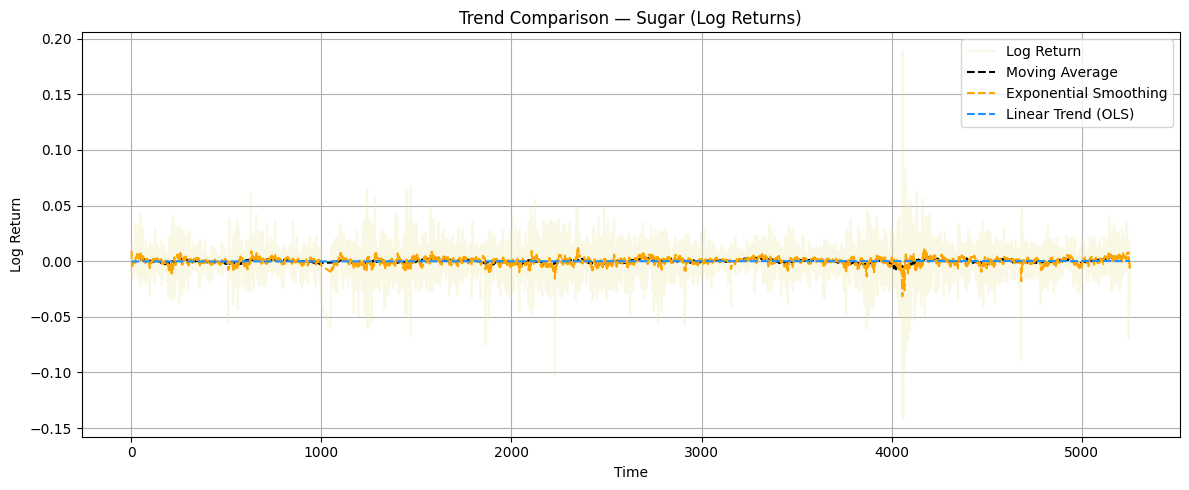

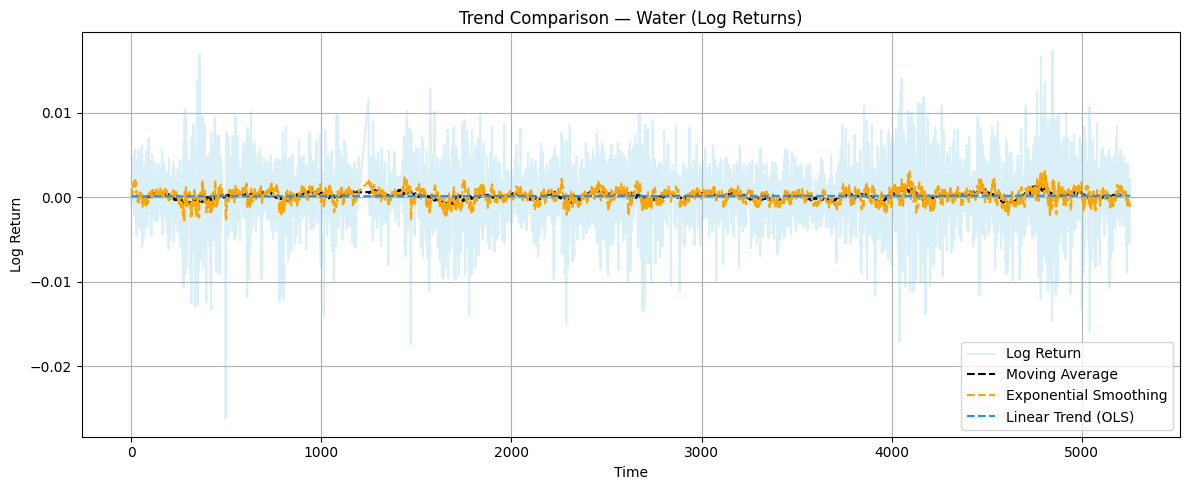

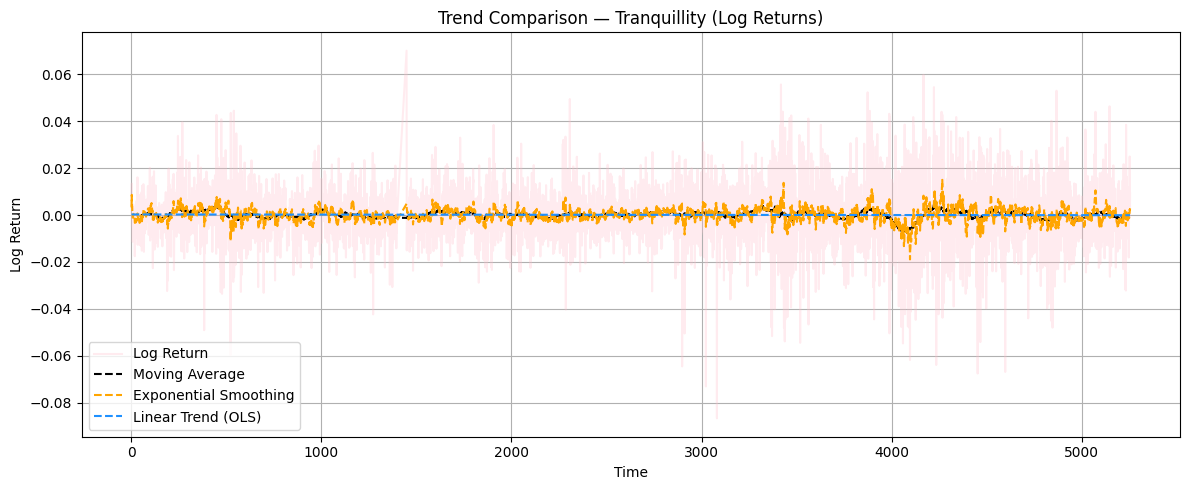

In [61]:
# Smoothing parameters
ma_window = 90         # 3-month window
ewma_alpha = 0.1       # smoothing factor for exponential
ols_trend_length = 5256 

# Apply trend analysis
for column, color in colours.items():
    series = df[column].dropna()
    log_return = np.log(series / series.shift(1)).dropna()

    # Time index for trend modeling
    x = np.arange(len(log_return)).reshape(-1, 1)

    # Linear regression (least squares)
    model = LinearRegression()
    model.fit(x[-ols_trend_length:], log_return[-ols_trend_length:])
    ols_trend = model.predict(x)

    # Moving Average
    ma_trend = log_return.rolling(window=ma_window, center=True).mean()

    # Exponential Weighted Moving Average
    ewma_trend = log_return.ewm(alpha=ewma_alpha).mean()

    # Plot all together
    plt.figure(figsize=(12, 5))
    plt.plot(log_return.index, log_return, label='Log Return', color=color, alpha=0.3)
    plt.plot(log_return.index, ma_trend, label='Moving Average', linestyle='--', color='black')
    plt.plot(log_return.index, ewma_trend, label='Exponential Smoothing', linestyle='--', color='orange')
    plt.plot(log_return.index, ols_trend, label='Linear Trend (OLS)', linestyle='--', color='dodgerblue')

    plt.title(f"Trend Comparison — {column.capitalize()} (Log Returns)")
    plt.xlabel("Time")
    plt.ylabel("Log Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
